<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>


# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [198]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import plotly.express as px
import plotly.io as pio
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


## Bibliotecas de Pré-Procesamento
from sklearn.preprocessing import MinMaxScaler

## Bibliotecas de Manipulação de Tempo
import time
import datetime

## Bibliotecas de Machine Learning e Deep Learning
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping

## Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

## Seed
import os
import random
import tensorflow as tf

# ========== SEED GLOBAL ==========
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

In [199]:
def analisa_estacionaridade(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1]) #posição do p_value é a mesma para ambos testes (posição 1)

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mEstacionária com nível de confiança de 95%\u001b[0m")
        else:
            print("\x1b[31mNão estacionária com nível de confiança de 95%\x1b[0m")
        print("\n")

In [200]:
def plota_acf_pacf(series, n_lags):
    fig, ax = plt.subplots(2,1, figsize = (12,5))
    fig = sm.graphics.tsa.plot_acf(series, lags=n_lags, ax=ax[0], auto_ylims=True)
    fig = sm.graphics.tsa.plot_pacf(series, lags=n_lags, ax=ax[1], auto_ylims=True)
    plt.tight_layout()
    plt.show()

In [201]:
def plota_histograma_boxplot_qq(variavel, df, titulo):
    mediana = df[variavel].median()
    media = round(df[variavel].mean(), 2)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histograma
    sns.histplot(data=df, x=variavel, bins=60, ax=axes[0], color='#1FB3E5', shrink=0.8)
    axes[0].axvline(x=mediana, ymax=0.75, color='#231F20', linestyle='-', label=f'Mediana = {mediana}')
    axes[0].axvline(x=media, ymax=0.75, color='#231F20', linestyle='--', label=f'Média = {media}')
    axes[0].set_title(f'Distribuição {titulo}', fontsize=14)
    axes[0].set_xlabel('Valores', fontsize=12)
    axes[0].set_ylabel('Frequência', fontsize=12)
    axes[0].legend(loc='best')
    axes[0].grid(False)
    axes[0].set_frame_on(False)

    # Boxplot
    sns.boxplot(data=df, x=variavel, ax=axes[1], color='#1FB3E5', orient='h')
    axes[1].set_title(f'Boxplot {titulo}', fontsize=14)
    axes[1].set_xlabel('Valores', fontsize=12)
    axes[1].grid(False)
    axes[1].set_frame_on(False)

    # QQ Plot
    stats.probplot(df[variavel].dropna(), dist="norm", plot=axes[2])
    axes[2].set_title(f'QQ Plot {titulo}', fontsize=14)
    axes[2].grid(False)
    axes[2].set_xlabel('Quantis Teóricos', fontsize=12)
    axes[2].set_ylabel('Quantis da Amostra', fontsize=12)

    plt.tight_layout()
    plt.show()


In [202]:
def ano_mes_dia(df):

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day


In [203]:
def separa_feature_target(target, vars_drop, dados):
    x = dados.drop([target]+vars_drop, axis = 1)
    y = dados[[target]]

    return x, y

In [204]:
def aplica_feature_selection(target, vars_drop, df, threshold):
    def remove_features_feature_importance(target, vars_drop, df, threshold):
        # Separa entre Features e Target
        x, y = separa_feature_target(target, vars_drop, df)
        
        # Criar o modelo de Random Forest
        model = RandomForestRegressor(
        random_state=42,            # Semente aleatória para reproducibilidade dos resultados
        criterion='squared_error',       # Critério usado para medir a qualidade de uma divisão
        n_estimators=50,           # Número de árvores na floresta (equivalente ao n_estimators no XGBoost)
        max_depth = 4,                # Profundidade máxima de cada árvore
        bootstrap=True               # Se deve ou não amostrar com substituição ao construir árvores
        )
        
        # Treinar o modelo
        model.fit(x, y)
        
        # Obter as importâncias das features
        feature_importances = model.feature_importances_
        
        # Selecionar as features com importância maior que zero
        selected_features = list(x.columns[feature_importances > threshold])
        selected_features.append(target)
        
        feature_importance_df = pd.DataFrame({
            'feature': x.columns,
            'importance': feature_importances
        }).sort_values(by='importance', ascending=False)
        feature_importance_df = feature_importance_df.loc[feature_importance_df['importance'] > 0]
        feature_importance_df['importance'] = feature_importance_df['importance'] * 100
        
        return selected_features, feature_importance_df

    def remove_features_altamente_correlacionadas(df, variaveis_importantes_df, threshold_correlacao=0.9):
        # Filtrar variáveis com alta importância
        alta_importancia_features = variaveis_importantes_df['feature'].tolist()
        
        # Selecionar as colunas do DataFrame com as variáveis de interesse
        df_reduzido = df[alta_importancia_features]
        
        # Calcular a matriz de correlação de Spearman
        correlacoes = df_reduzido.corr(method='spearman')
        
        # Encontrar variáveis altamente correlacionadas
        alta_correlacao = np.abs(correlacoes) > threshold_correlacao
        features_para_remover = set()
        
        for i in range(len(alta_correlacao.columns)):
            for j in range(i):
                if alta_correlacao.iloc[i, j] and correlacoes.columns[j] not in features_para_remover:
                    features_para_remover.add(correlacoes.columns[i])
        
        variaveis_filtradas = [col for col in alta_importancia_features if col not in features_para_remover]
        
        return variaveis_filtradas
    
    # Aplicando Random Forest e selecionado feature com importância > 0
    features, feature_importances = remove_features_feature_importance(target, vars_drop, df, threshold)
    feature_importances = feature_importances.loc[feature_importances['importance'] > 0]
    
    # Filtrar variáveis altamente correlacionadas e mantendo a que possui maior importância com a target dentre as correlacionadas
    variaveis_selecionadas = remove_features_altamente_correlacionadas(df, feature_importances)
    feature_importances_final = feature_importances[feature_importances['feature'].isin(variaveis_selecionadas)]

    return feature_importances_final


In [205]:
def metricas(modelo, y_true, y_predict):

    mae = mean_absolute_error(y_predict, y_true)
    mse = mean_squared_error(y_predict, y_true)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_predict, y_true)
    metricas = pd.DataFrame(
        {
            'MAE':mae, 
            'RMSE':rmse, 
            'MAPE':mape,
            'modelo':modelo
        }, index = np.arange(1, 2))

    return metricas



# <font color='red' style='font-size: 40px;'> 1) Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição das Variáveis </font>
<hr style='border: 2px solid green;'>

### 1.1.1) Cases

1. **Date:** Data

2. **meantemp:** Temperatura média medida por 3 intervalos de tempo no dia

3. **humidty:** Humidade (unidade: gramas de vapor/volume de ar por metro cúbico)

4. **wind_speed:** Velocidade do Vento

5. **meanpressure:** Pressão atmosférica

In [206]:
df_climate = pd.read_csv('./data/DailyDelhiClimateTrain.csv')
ano_mes_dia(df_climate)
df_climate = df_climate[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]

# <font color='red' style='font-size: 40px;'> 2) Análise Exploratória </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Como é a distribuição das variáveis ? </font>
<hr style='border: 2px solid green;'>

> 1. As distribuições parecem estáveis, de modo que não vemos valores tão extremos que nos levariam a achar que foi um erro

> 2. A Pressão Atmosférica apresenta um caso de valor negativo (está medida em ATM, então é impossível) e há um valor de 7679 que é muito diferente do resto da distribuição, portanto, pode-se considerá-lo um erro de medição

> 3. Não há dados ausentes, porém, caso houvesse poderíamos imputá-los com a média móvel de T períodos anteriores

In [207]:
df_climate.describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

,month,year,meantemp,humidity,wind_speed,meanpressure
count,1462.00,1462.00,1462.00,1462.00,1462.00,1462.00
mean,6.52,2014.50,25.50,60.77,6.80,1011.10
std,3.45,1.12,7.35,16.77,4.56,180.23
min,1.00,2013.00,6.00,13.43,0.00,-3.04
1%,1.00,2013.00,9.95,22.22,0.00,994.20
5%,1.00,2013.00,12.51,29.00,0.93,996.83
10%,2.00,2013.00,14.62,36.21,1.62,998.14
20%,3.00,2013.00,17.62,47.25,2.91,1000.54
30%,4.00,2014.00,21.13,53.24,4.16,1002.74
40%,5.00,2014.00,24.50,58.05,5.18,1005.35


In [208]:
df_climate.isnull().sum()

date            0
month           0
year            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

# <font color='green' style='font-size: 30px;'> 2.2) Como se comporta o a temperatura, humidade, velocidade do vento e a pressão atmosférica ao longo do tempo ? </font>
<hr style='border: 2px solid green;'>

> 1. A temperatura e a humidade aparentam sofrer ciclos, sazonalidades e tendências de subida e descida

> 2. A velocidade do vento parece ser um pouco mais estacionária, mas visualmente não é possível ter certeza

> 3. A pressão atmosférica está com o gráfico deturpado devido a presença de Outliers Inferiores e Superiores Extremos, portanto, deveríamos retirá-los para termos compreensao da série histórica

> 4. Retirando os Outliers, a pressão atmosférica parece sofrer ciclos, sazonalidades e tendências de subida e descida, mas o interessante é que ela é inversamento proporcional a temperatura

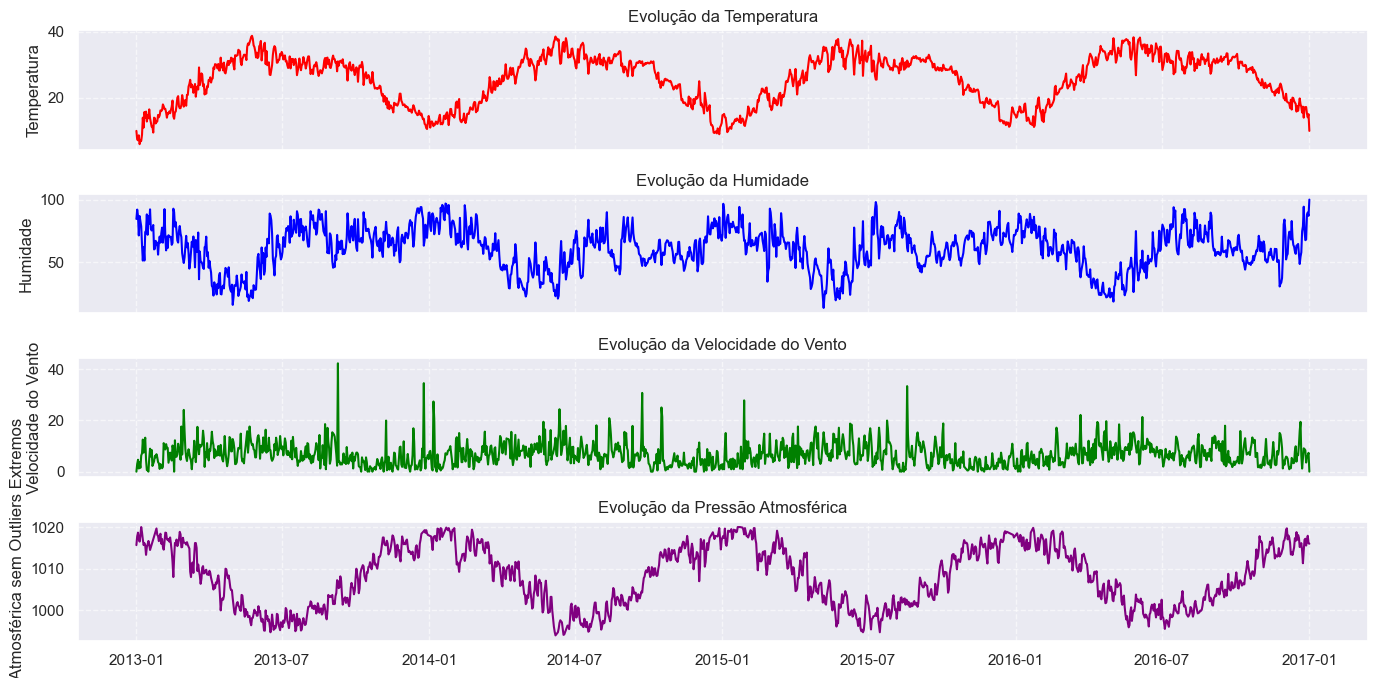

In [209]:
# Criando a figura e os subplots
fig, ax = plt.subplots(4, 1, figsize=(14, 7), sharex=True)  # 4 linhas, 1 coluna

# Gráfico de Temperatura
ax[0].plot(df_climate['date'], df_climate['meantemp'], linestyle='-', color='red')
ax[0].set_ylabel("Temperatura")
ax[0].set_title("Evolução da Temperatura")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Humidade
ax[1].plot(df_climate['date'], df_climate['humidity'], linestyle='-', color='blue')
ax[1].set_ylabel("Humidade")
ax[1].set_title("Evolução da Humidade")
ax[1].grid(True, linestyle="--", alpha=0.6)


# Gráfico de Velocidade do Vento
ax[2].plot(df_climate['date'], df_climate['wind_speed'], linestyle='-', color='green')
ax[2].set_ylabel("Velocidade do Vento")
ax[2].set_title("Evolução da Velocidade do Vento")
ax[2].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Pressão Atmosférica sem Outliers Extremos
ax[3].plot(df_climate.loc[df_climate['meanpressure'].between(994, 1020)]['date'], df_climate.loc[df_climate['meanpressure'].between(994, 1020)]['meanpressure'], linestyle='-', color='purple')
ax[3].set_ylabel("Pressão Atmosférica sem Outliers Extremos")
ax[3].set_title("Evolução da Pressão Atmosférica")
ax[3].grid(True, linestyle="--", alpha=0.6)


# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


# <font color='green' style='font-size: 30px;'> 2.3) Como se comportam as componentes temporais da série histórica? </font>
<hr style='border: 2px solid green;'>

> 1. Trataremos as componentes através de um Modelo Aditivo

> 2. Modelos aditivos em séries temporais são um tipo de abordagem utilizada para decompor uma série temporal em componentes distintos que podem ser somados para explicar a variação nos dados ao longo do tempo. Esses componentes tipicamente incluem:

- Tendência (Trend): Representa a direção geral dos dados ao longo do tempo (por exemplo, uma tendência crescente ou decrescente).

- Sazonalidade (Seasonality): Captura padrões repetitivos que ocorrem em intervalos regulares (por exemplo, variações sazonais mensais ou anuais).

- Ciclo (Cycle): Refere-se a flutuações de longo prazo que não são devidas a sazonalidade (por exemplo, ciclos econômicos).

- Ruído (Noise): Componentes aleatórios ou erros que não são explicados pelos outros componentes.

## $$ Y_{t} = S_{t} + T{t} + R{t} $$ 

> 3. Podemos testar estacionaridade usando o Teste KPSS e o Dickey-Fuller

No KPSS o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| KPSS | É estacionária | Não é estacionária |

</center>

- O [teste KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) (Kwiatkowski-Phillips-Schmidt-Shin) compara a série temporal com um modelo estacionário que tem características semelhantes à série. Ele avalia a diferença entre a série real e o modelo estacionário para determinar se a série é estacionária ou não.

- H0: É estacionário --> Não rejeitada caso p-value > 0.05

- H1: Não é estacionário --> Rejeição de H0 caso p-value <= 0.05

No ADF o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| ADF | Não é estacionária | É estacionária |

</center>

- O [teste de Dickey-Fuller Aumentado](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) é um teste estatístico utilizado para verificar a presença de raiz unitária em uma série temporal. Uma série temporal é considerada ter uma raiz unitária se ela não for estacionária, ou seja, se sua média e variância não forem constantes ao longo do tempo. Essa verificação acontece comparando a série temporal original com uma versão diferenciada da mesma. Ele compara a série temporal original com uma versão diferenciada da série. A diferenciação envolve subtrair cada valor da série pelo valor anterior, o que pode ajudar a remover tendências ou padrões de longo prazo na série. 

- H0: Não é estacionário --> Não rejeitada caso p-value > 0.05

- H1: É estacionário --> Rejeição de H0 caso p-value <= 0.05


> 4. Pela análise gráfica, nota-se que nenhuma das séries é estacionária, mesmo que o Teste de Hipótese afirme que sim

- A série possui tendência e claramente não possui variância constante

> 5. Além disso, a série apresenta sazonalidade de aproximadamente 1 ano, com alternância das Lags a cada 180 Lags, sugerindo a metade do ciclo

Adfuller
p-value: 0.277
Não estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




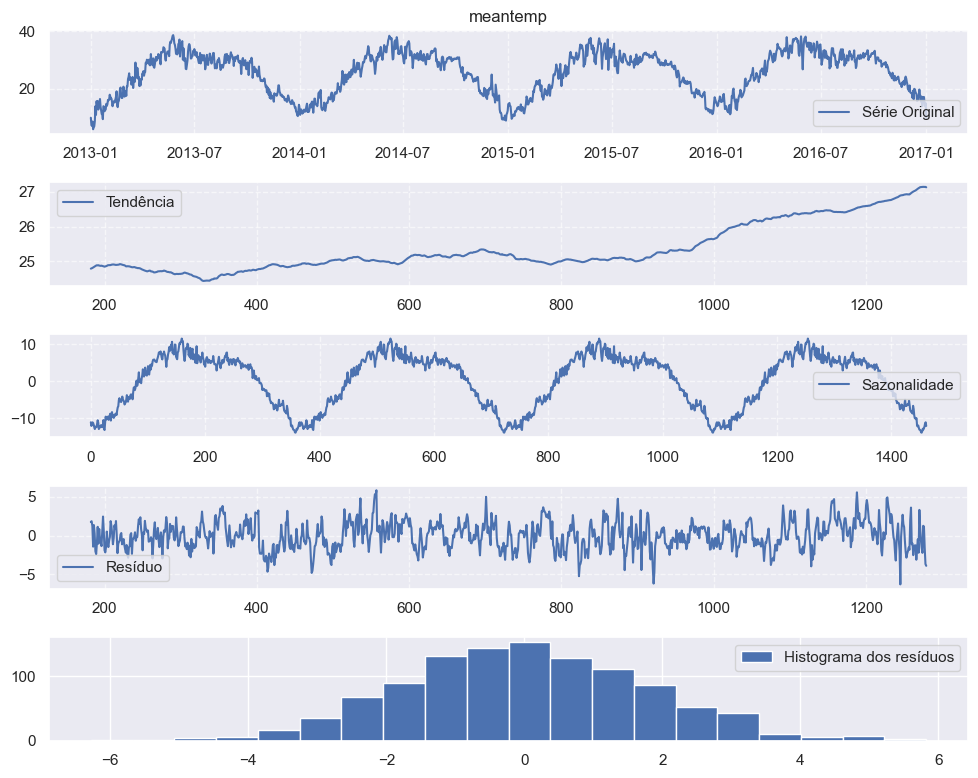

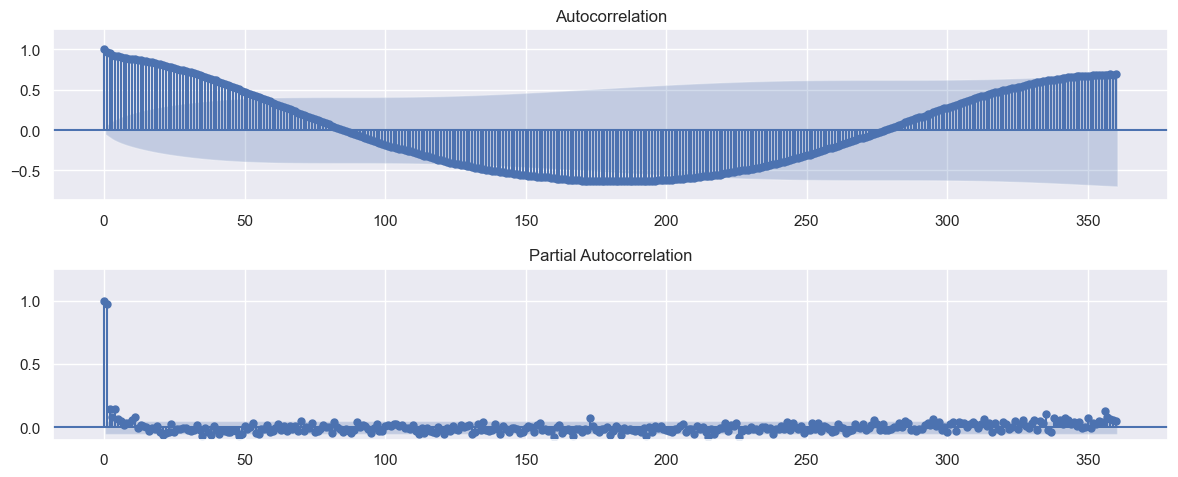

In [210]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate['meantemp'], model='additive', period=365)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 
analisa_estacionaridade(df_climate['meantemp'])

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate['date'], df_climate['meantemp'], label='Série Original')
plt.title('meantemp')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate['meantemp'], 360)


# <font color='green' style='font-size: 30px;'> 2.4) Como são as distribuições das séries? </font>
<hr style='border: 2px solid green;'>

> 1. Em séries temporais, histogramas da série não-transformada não informam muita coisa, uma vez que espera-se que a distribuição não seja Normal devido a presença de tendências

> 2. Dessa forma, recomenda-se avaliar a distribuição da série diferenciada, pois caso ela seja uma Normal, pode-se inferir que o valor no tempo T está autocorrelacionada com o valor no tempo T-1

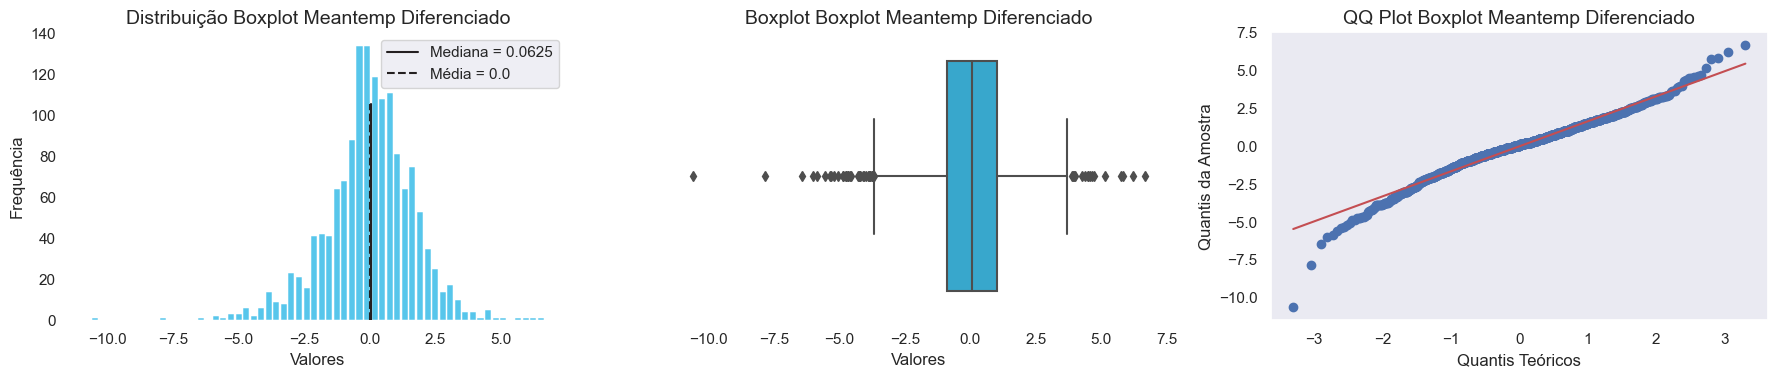

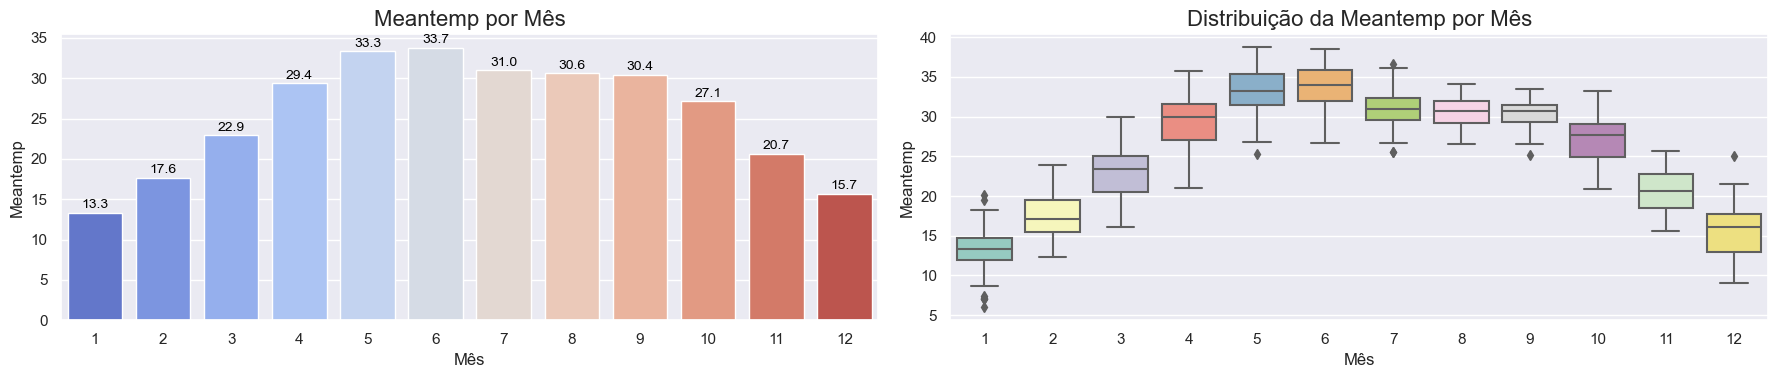

In [211]:
df_climate['meantemp_diff1'] = df_climate['meantemp'].diff()
plota_histograma_boxplot_qq('meantemp_diff1', df_climate, f'Boxplot Meantemp Diferenciado')
monthly_avg = df_climate.groupby('month')['meantemp'].mean().reset_index()
# Criar os subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Gráfico 1: Média por Mês
sns.barplot(
    data=monthly_avg,
    x='month',
    y='meantemp',
    palette='coolwarm',
    ax=axes[0]  #
)
axes[0].set_title(f'Meantemp por Mês', fontsize=16)
axes[0].set_xlabel('Mês', fontsize=12)
axes[0].set_ylabel(f'Meantemp', fontsize=12)

for index, row in monthly_avg.iterrows():
    axes[0].text(
        row.name, 
        row['meantemp'] + 0.2, 
        f"{row['meantemp']:.1f}", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )


# Gráfico 2: Distribuição por Mês (Boxplot)
sns.boxplot(
    data=df_climate,
    x='month',
    y='meantemp',
    palette='Set3',
    ax=axes[1]  #
)
axes[1].set_title(f'Distribuição da Meantemp por Mês', fontsize=16)
axes[1].set_xlabel('Mês', fontsize=12)
axes[1].set_ylabel(f'Meantemp', fontsize=12)

# Layout final
plt.tight_layout()
plt.show()

# <font color='green' style='font-size: 30px;'> 2.5) Como fica a série diferenciada? </font>
<hr style='border: 2px solid green;'>

> 1. Quanto maior a diferenciação, mais estacionária a série parece se comportar

> 2. A Diferenciação de 2 Ordem tornou a série estacionária

> 3. Pela Queda Abrupta no ACF e pela Queda Gradual no PACF, há indícios desse modelo ter ordem AR e ordem MA

> 4. Mesmo com a série aparentemente estacionária, ainda há alta variância em alguns pontos e não necessariamente a sazonalidade deixou de existir

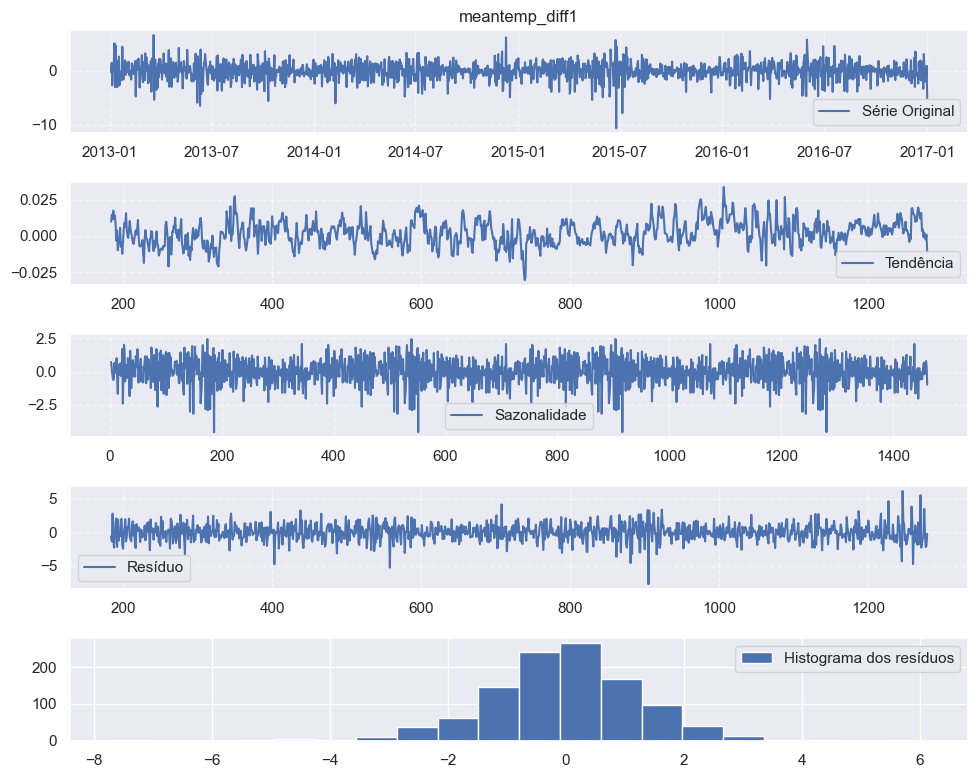

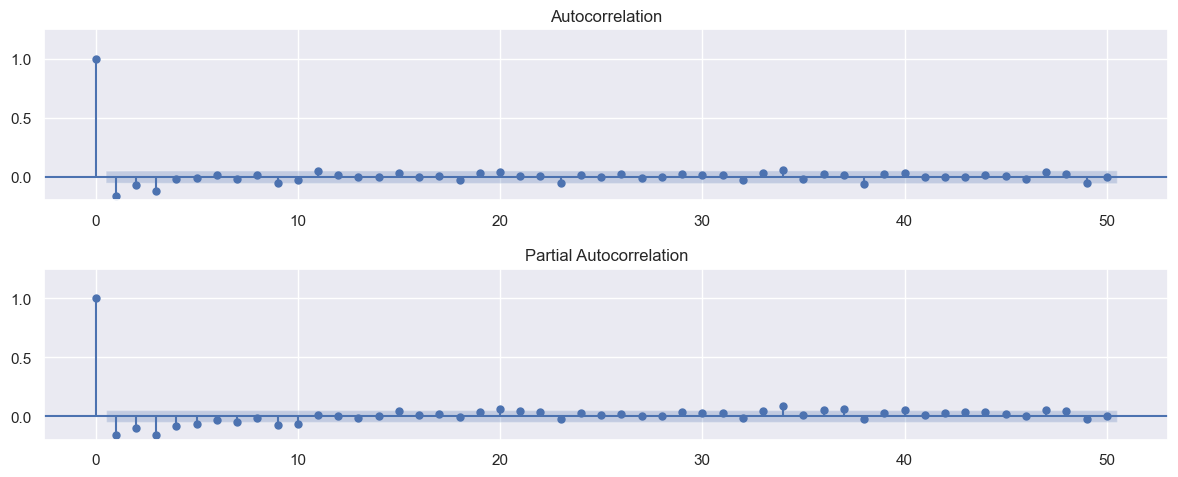

Adfuller
p-value: 0.000
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [212]:
df_climate['meantemp_diff1'] = df_climate['meantemp'].diff()
df_climate['meantemp_diff2'] = df_climate['meantemp'].diff().diff()

df_climate.dropna(inplace = True)

# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate['meantemp_diff1'], model='additive', period=365)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate['date'], df_climate['meantemp_diff1'], label='Série Original')
plt.title('meantemp_diff1')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate['meantemp_diff1'], 50)

analisa_estacionaridade(df_climate['meantemp_diff1'])

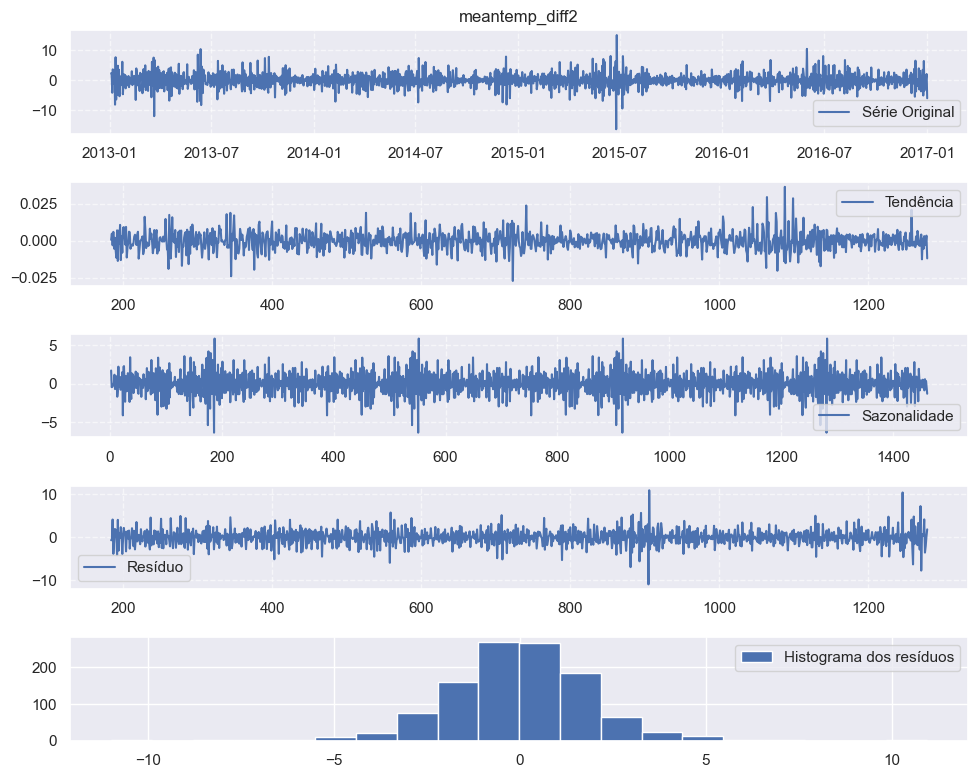

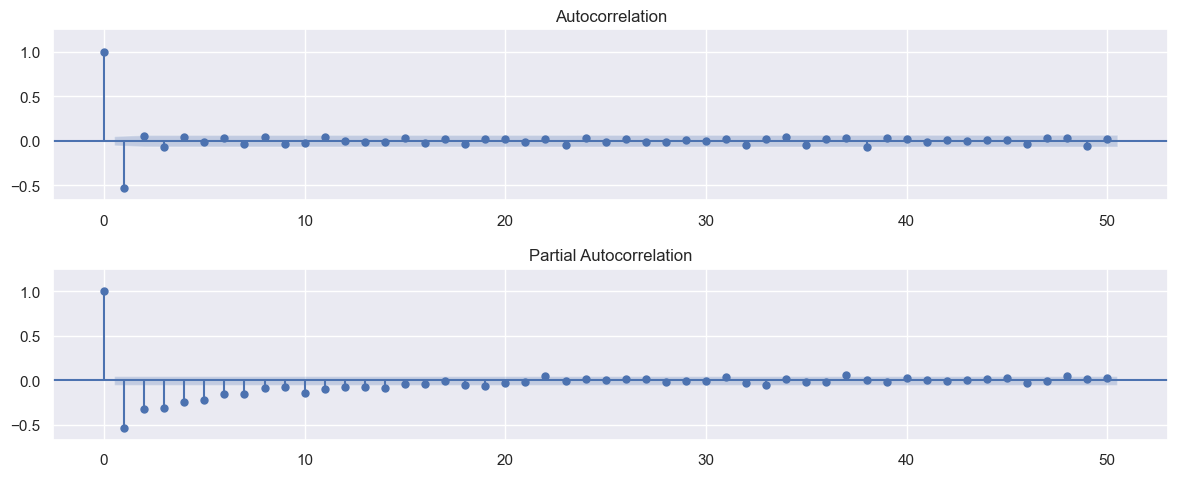

Adfuller
p-value: 0.000
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [213]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate['meantemp_diff2'], model='additive', period=365)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate['date'], df_climate['meantemp_diff2'], label='Série Original')
plt.title('meantemp_diff2')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate['meantemp_diff2'], 50)

analisa_estacionaridade(df_climate['meantemp_diff2'])

# <font color='green' style='font-size: 30px;'> 2.6) Existe correlação entre as séries? </font>
<hr style='border: 2px solid green;'>

> 1. Em séries temporais, a correlação deve ser analisada entre a Variável Resposta no tempo T e as Covariáveis no tempo T-1, pois objetiva-se entender se as variáveis possuem poder preditivo

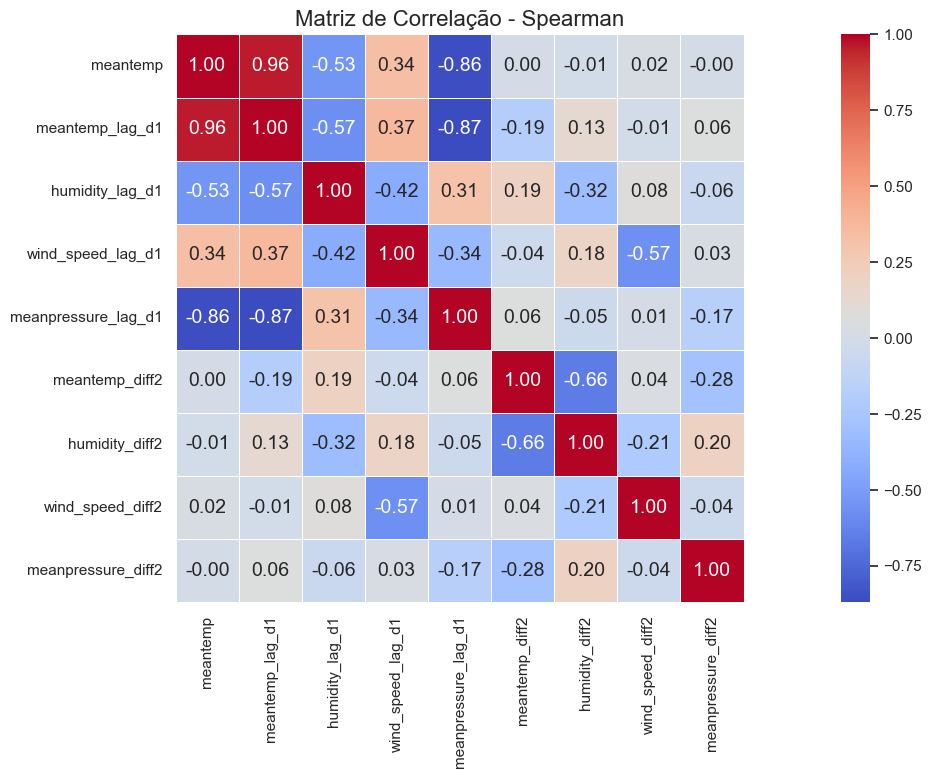

In [214]:
df_climate_corr = df_climate.drop(['month', 'year'], axis = 1).copy()
df_climate_corr['meantemp_lag_d1'] = df_climate_corr['meantemp'].shift(1)
df_climate_corr['humidity_lag_d1'] = df_climate_corr['humidity'].shift(1)
df_climate_corr['wind_speed_lag_d1'] = df_climate_corr['wind_speed'].shift(1)
df_climate_corr['meanpressure_lag_d1'] = df_climate_corr['meanpressure'].shift(1)

df_climate_corr['meantemp_diff2'] = df_climate_corr['meantemp'].diff().diff()
df_climate_corr['humidity_diff2'] = df_climate_corr['humidity'].diff().diff()
df_climate_corr['wind_speed_diff2'] = df_climate_corr['wind_speed'].diff().diff()
df_climate_corr['meanpressure_diff2'] = df_climate_corr['meanpressure'].diff().diff()

plt.figure(figsize=(20, 8))

sns.heatmap(
    df_climate_corr[['meantemp', 'meantemp_lag_d1', 'humidity_lag_d1', 'wind_speed_lag_d1', 'meanpressure_lag_d1', 'meantemp_diff2', 'humidity_diff2', 'wind_speed_diff2', 'meanpressure_diff2']].corr(method = 'spearman'),
    annot=True,     
    cmap='coolwarm',
    fmt=".2f",      
    linewidths=0.5, 
    square=True     
)

plt.title("Matriz de Correlação - Spearman", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# <font color='red' style='font-size: 40px;'> 3) Amostragem, Pré-Processamento e Feature Engineering  </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 3.1) Amostragem </font>
<hr style='border: 2px solid green;'>

> 1. Separou-se 1 ano e 8 meses para Treino, 2 meses para Validação e 2 meses para Teste

In [215]:
# Data
df_climate = pd.read_csv('./data/DailyDelhiClimateTrain.csv')
ano_mes_dia(df_climate)
df_climate = df_climate[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]

#Train-Valid-Test

df_train = df_climate.loc[df_climate['date'].between('2015-01-01', '2016-08-31')]
df_train['sample'] = 'train'
df_valid = df_climate.loc[df_climate['date'].between('2016-09-01', '2016-10-31')]
df_valid['sample'] = 'valid'
df_test = df_climate.loc[df_climate['date'].between('2016-11-01', '2016-12-31')]
df_test['sample'] = 'test'


df_model = pd.concat([df_train, df_valid, df_test], axis=0)


# <font color='green' style='font-size: 30px;'> 3.2) Pré-Processamento e Feature Engineering </font>
<hr style='border: 2px solid green;'>

> 1. Substituiu-se valores extremos (prováveis erros de medição) pela mediana 

> 2. Criou-se diversas variáveis temporais

> 3. Testou-se o comportamento da série comparando a série original com a diferenciação de 2 Ordem, Log e Log com Diferenciação de 2 Ordem. A série é estacionária com a diferenciaçao, mas a variância e a sazonalidade ainda existem

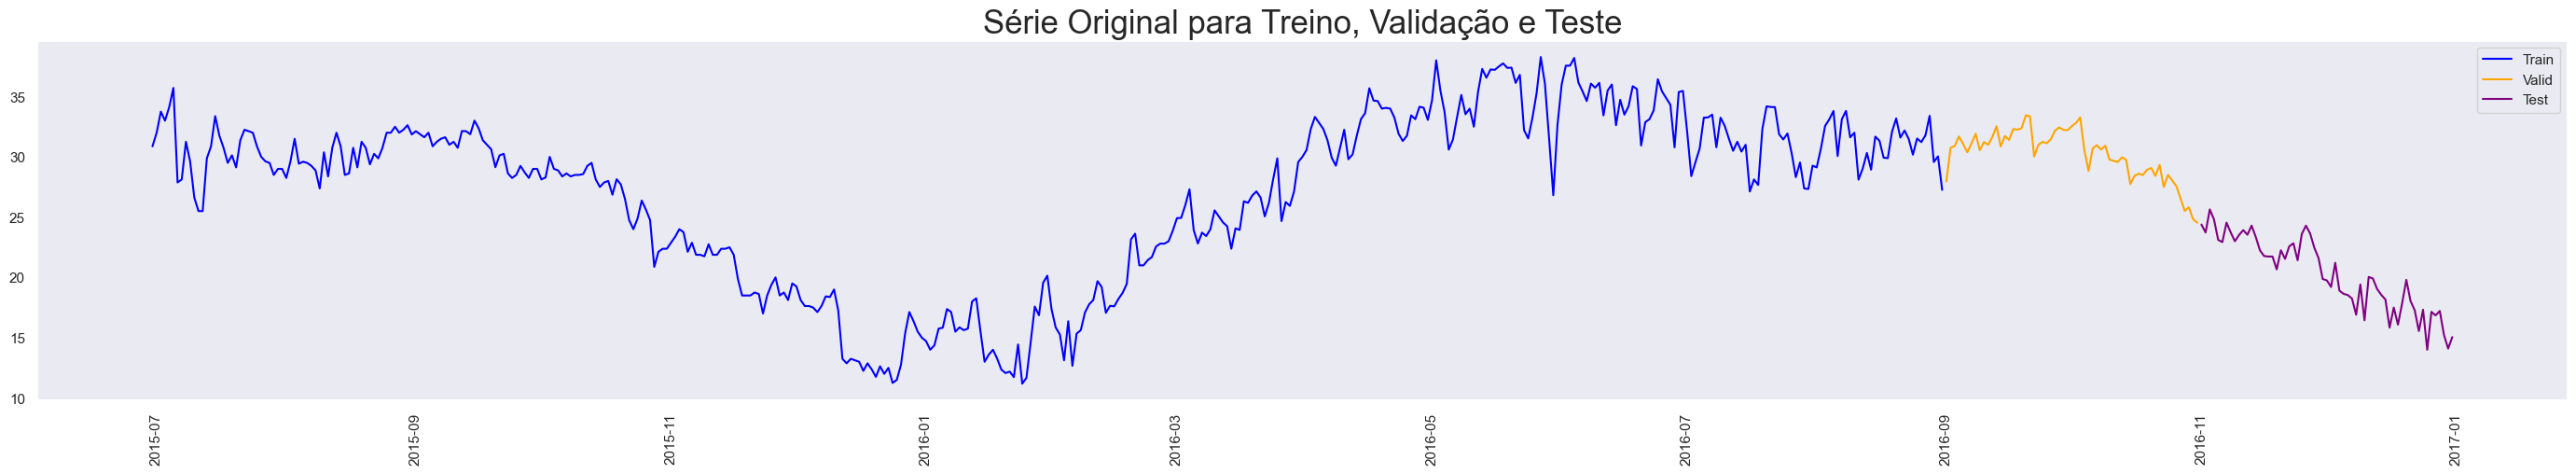

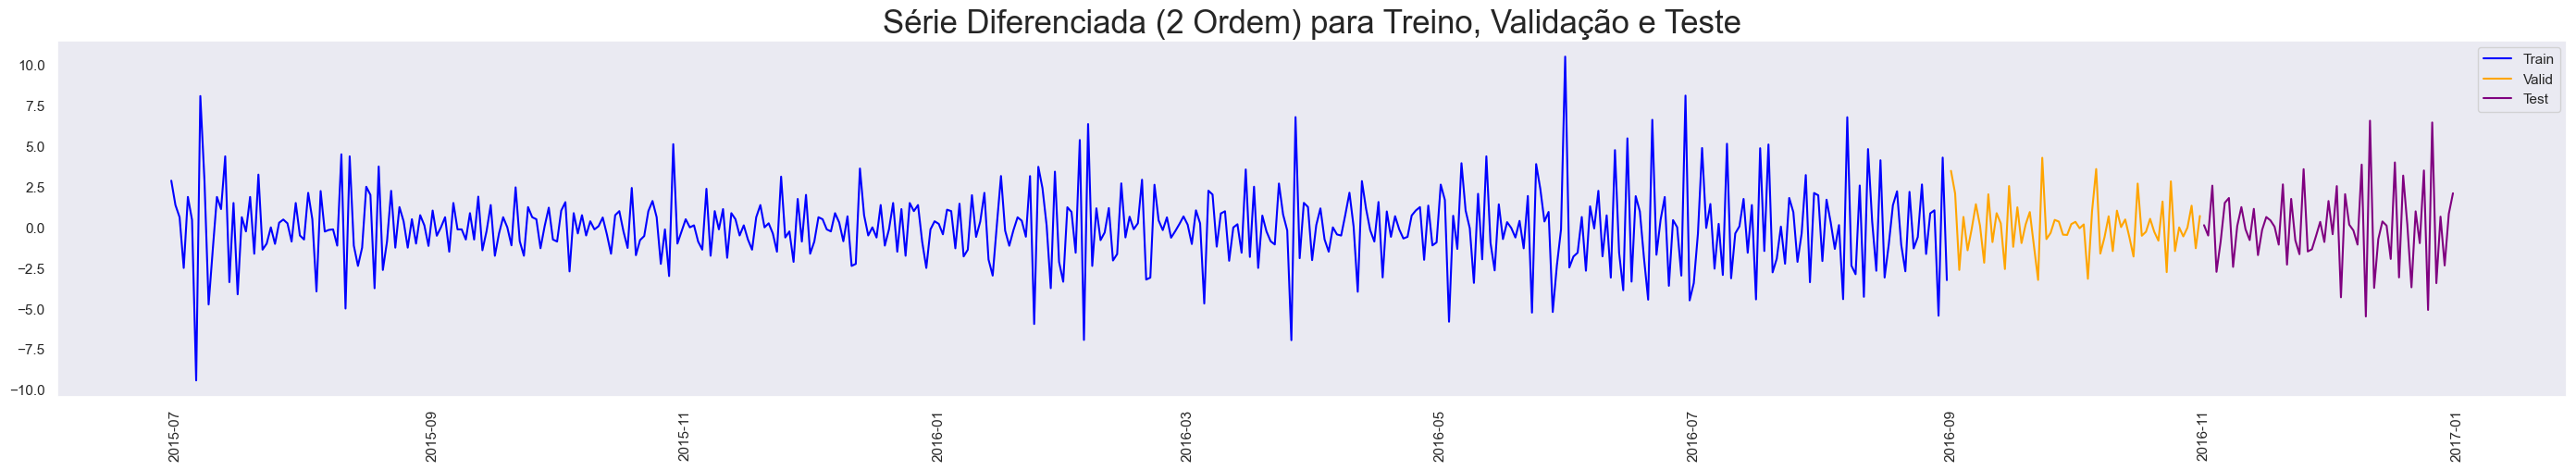

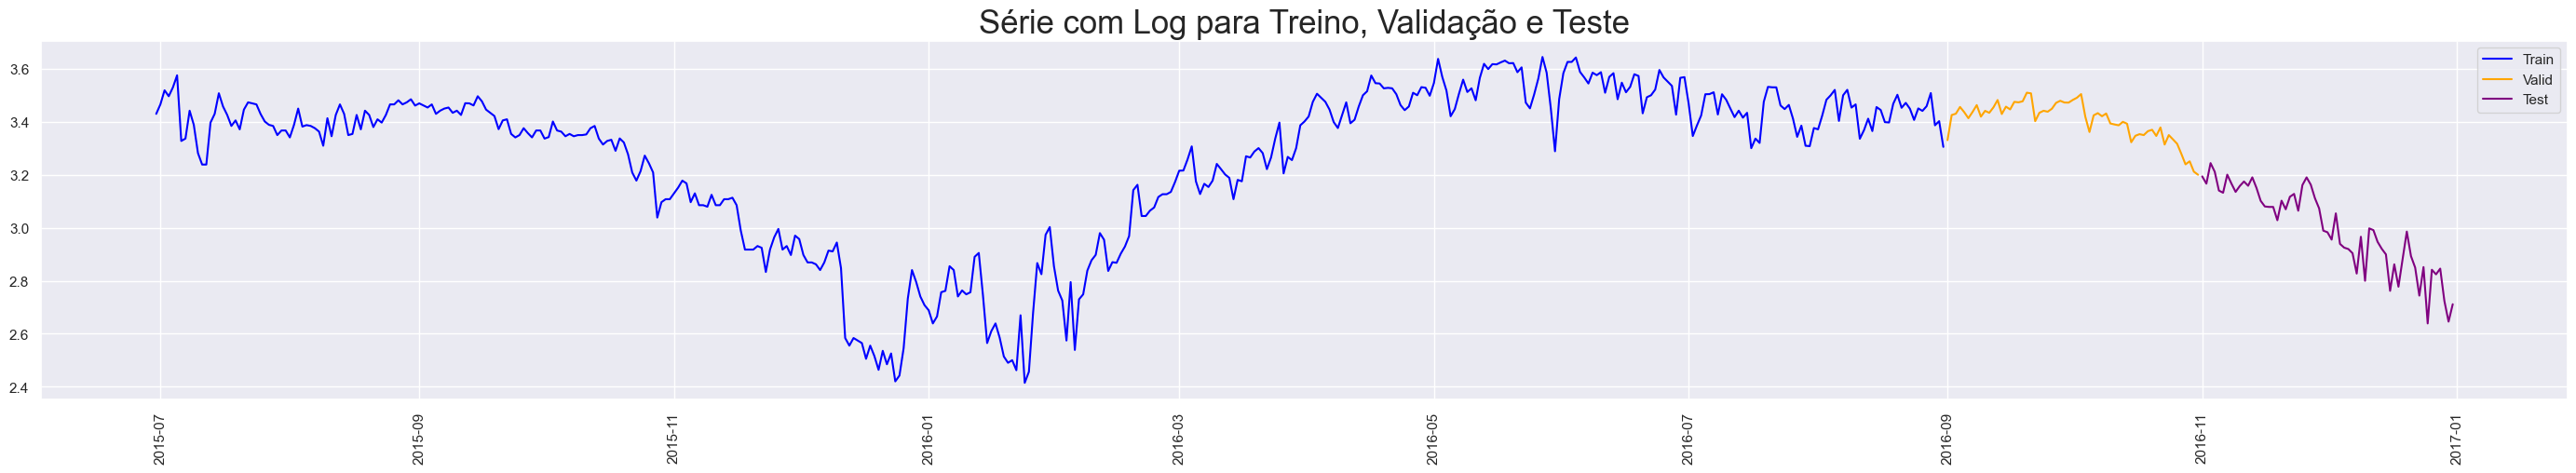

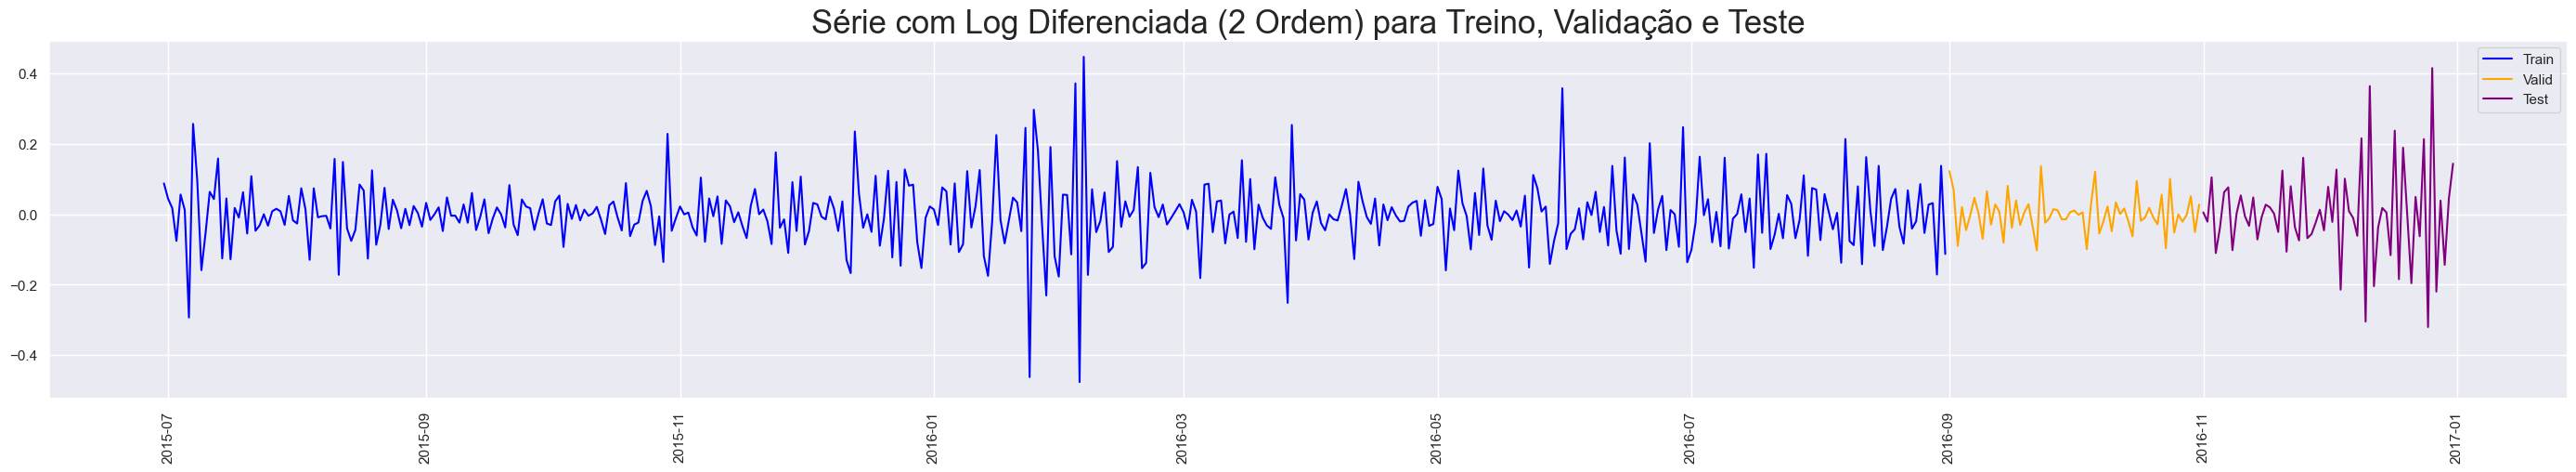

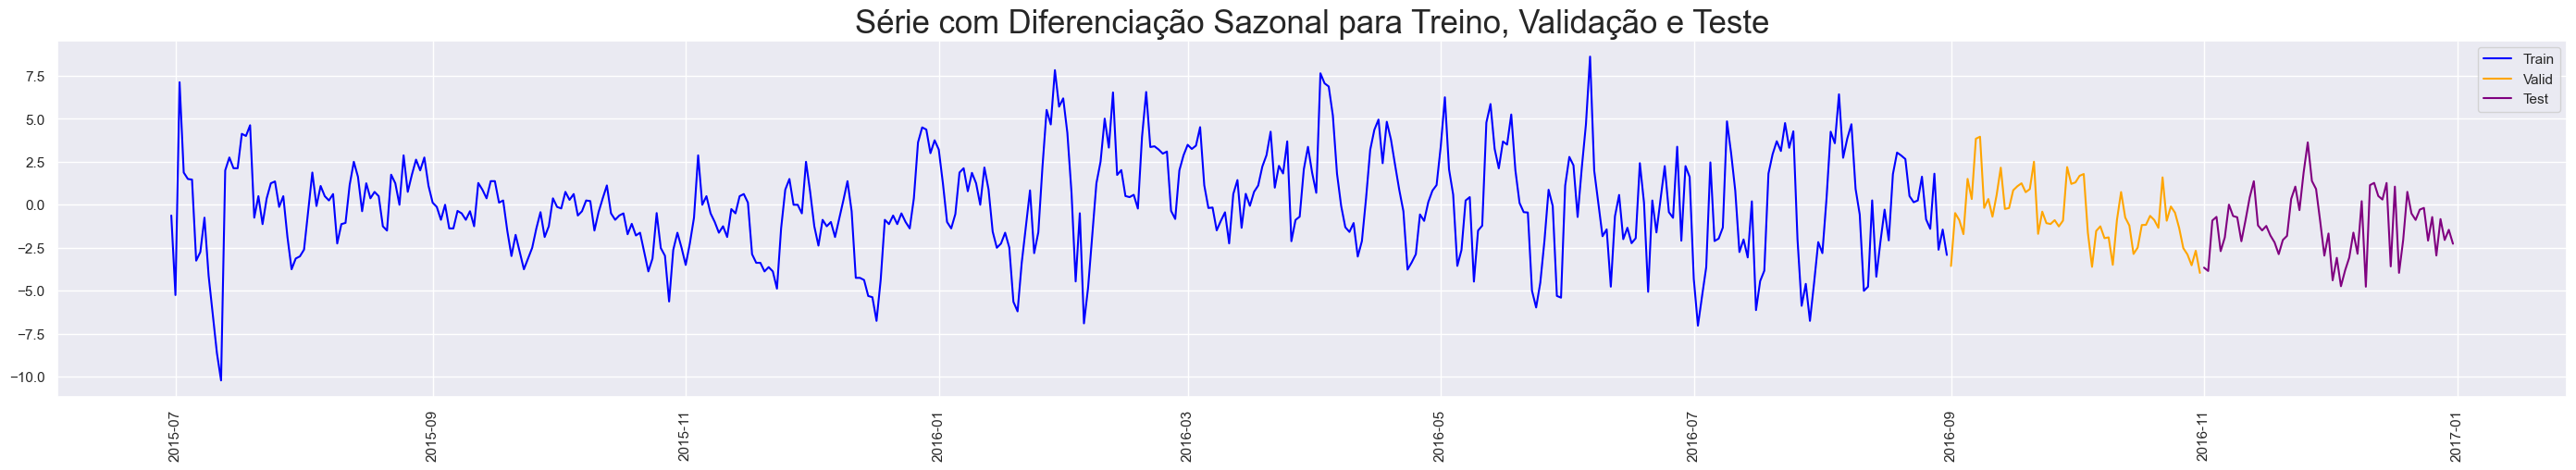

In [216]:

# Pre-Processamento
meanpreassure_imputer_train = df_train.meanpressure.median()
df_model['meanpressure'] = np.where(df_model['meanpressure'].between(994, 1020), df_model['meanpressure'], meanpreassure_imputer_train)

# Features
df_model['month'] = df_model['date'].dt.month

df_model['meantemp_log'] = np.log(df_model['meantemp'])
df_model['meantemp_diff2'] = df_model['meantemp'].diff().diff()
df_model['meantemp_log_diff2'] = df_model['meantemp_log'].diff().diff()
df_model['meantemp_seasonal_diff'] = df_model['meantemp'].diff(7)

df_model['meantemp_lag_d1'] = df_model['meantemp'].shift(1)
df_model['meantemp_lag_d2'] = df_model['meantemp'].shift(2)
df_model['meantemp_lag_d3'] = df_model['meantemp'].shift(3)
df_model['meantemp_lag_m1'] = df_model['meantemp'].shift(30)
df_model['meantemp_lag_m3'] = df_model['meantemp'].shift(90)
df_model['meantemp_lag_m6'] = df_model['meantemp'].shift(180)
df_model['meantemp_media_movel_d3'] = df_model['meantemp'].shift(1).rolling(3).mean()
df_model['meantemp_media_movel_m1'] = df_model['meantemp'].shift(1).rolling(30).mean()
df_model['meantemp_media_movel_m3'] = df_model['meantemp'].shift(1).rolling(90).mean()
df_model['meantemp_media_movel_m6'] = df_model['meantemp'].shift(1).rolling(180).mean()

df_model['humidity_lag_d1'] = df_model['humidity'].shift(1)
df_model['humidity_lag_d2'] = df_model['humidity'].shift(2)
df_model['humidity_lag_d3'] = df_model['humidity'].shift(3)
df_model['humidity_lag_m1'] = df_model['humidity'].shift(30)
df_model['humidity_lag_m3'] = df_model['humidity'].shift(90)
df_model['humidity_lag_m6'] = df_model['humidity'].shift(180)
df_model['humidity_media_movel_d3'] = df_model['humidity'].shift(1).rolling(3).mean()
df_model['humidity_media_movel_m1'] = df_model['humidity'].shift(1).rolling(30).mean()
df_model['humidity_media_movel_m3'] = df_model['humidity'].shift(1).rolling(90).mean()
df_model['humidity_media_movel_m6'] = df_model['humidity'].shift(1).rolling(180).mean()

df_model['wind_speed_lag_d1'] = df_model['wind_speed'].shift(1)
df_model['wind_speed_lag_d2'] = df_model['wind_speed'].shift(2)
df_model['wind_speed_lag_d3'] = df_model['wind_speed'].shift(3)
df_model['wind_speed_lag_m1'] = df_model['wind_speed'].shift(30)
df_model['wind_speed_lag_m3'] = df_model['wind_speed'].shift(90)
df_model['wind_speed_lag_m6'] = df_model['wind_speed'].shift(180)
df_model['wind_speed_media_movel_d3'] = df_model['wind_speed'].shift(1).rolling(3).mean()
df_model['wind_speed_media_movel_m1'] = df_model['wind_speed'].shift(1).rolling(30).mean()
df_model['wind_speed_media_movel_m3'] = df_model['wind_speed'].shift(1).rolling(90).mean()
df_model['wind_speed_media_movel_m6'] = df_model['wind_speed'].shift(1).rolling(180).mean()

df_model['meanpressure_lag_d1'] = df_model['meanpressure'].shift(1)
df_model['meanpressure_lag_d2'] = df_model['meanpressure'].shift(2)
df_model['meanpressure_lag_d3'] = df_model['meanpressure'].shift(3)
df_model['meanpressure_lag_m1'] = df_model['meanpressure'].shift(30)
df_model['meanpressure_lag_m3'] = df_model['meanpressure'].shift(90)
df_model['meanpressure_lag_m6'] = df_model['meanpressure'].shift(180)
df_model['meanpressure_media_movel_d3'] = df_model['meanpressure'].shift(1).rolling(3).mean()
df_model['meanpressure_media_movel_m1'] = df_model['meanpressure'].shift(1).rolling(30).mean()
df_model['meanpressure_media_movel_m3'] = df_model['meanpressure'].shift(1).rolling(90).mean()
df_model['meanpressure_media_movel_m6'] = df_model['meanpressure'].shift(1).rolling(180).mean()

df_model = df_model.dropna().copy()

df_model_train = df_model.loc[df_model['sample'] == 'train']
df_model_valid = df_model.loc[df_model['sample'] == 'valid']
df_model_test = df_model.loc[df_model['sample'] == 'test']

plt.figure(figsize=(35,5))
plt.grid()

plt.plot(df_model.loc[df_model['sample'] == 'train']['date'], 
         df_model.loc[df_model['sample'] == 'train']['meantemp'], 
         label='Train', color = 'blue')

plt.plot(df_model.loc[df_model['sample'] == 'valid']['date'], 
         df_model.loc[df_model['sample'] == 'valid']['meantemp'], 
         label='Valid', color = 'orange')

plt.plot(df_model.loc[df_model['sample'] == 'test']['date'], 
         df_model.loc[df_model['sample'] == 'test']['meantemp'], 
         label='Test', color = 'purple')

plt.title('Série Original para Treino, Validação e Teste', fontsize = 25)
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(35,5))
plt.grid()

plt.plot(df_model.loc[df_model['sample'] == 'train']['date'], 
         df_model.loc[df_model['sample'] == 'train']['meantemp_diff2'], 
         label='Train', color = 'blue')

plt.plot(df_model.loc[df_model['sample'] == 'valid']['date'], 
         df_model.loc[df_model['sample'] == 'valid']['meantemp_diff2'], 
         label='Valid', color = 'orange')

plt.plot(df_model.loc[df_model['sample'] == 'test']['date'], 
         df_model.loc[df_model['sample'] == 'test']['meantemp_diff2'], 
         label='Test', color = 'purple')
plt.title('Série Diferenciada (2 Ordem) para Treino, Validação e Teste', fontsize = 25)
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(35,5))
plt.plot(df_model.loc[df_model['sample'] == 'train']['date'], 
         df_model.loc[df_model['sample'] == 'train']['meantemp_log'], 
         label='Train', color = 'blue')

plt.plot(df_model.loc[df_model['sample'] == 'valid']['date'], 
         df_model.loc[df_model['sample'] == 'valid']['meantemp_log'], 
         label='Valid', color = 'orange')

plt.plot(df_model.loc[df_model['sample'] == 'test']['date'], 
         df_model.loc[df_model['sample'] == 'test']['meantemp_log'], 
         label='Test', color = 'purple')
plt.title('Série com Log para Treino, Validação e Teste', fontsize = 25)
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(35,5))
plt.plot(df_model.loc[df_model['sample'] == 'train']['date'], 
         df_model.loc[df_model['sample'] == 'train']['meantemp_log_diff2'], 
         label='Train', color = 'blue')

plt.plot(df_model.loc[df_model['sample'] == 'valid']['date'], 
         df_model.loc[df_model['sample'] == 'valid']['meantemp_log_diff2'], 
         label='Valid', color = 'orange')

plt.plot(df_model.loc[df_model['sample'] == 'test']['date'], 
         df_model.loc[df_model['sample'] == 'test']['meantemp_log_diff2'], 
         label='Test', color = 'purple')
plt.title('Série com Log Diferenciada (2 Ordem) para Treino, Validação e Teste', fontsize = 25)
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(35,5))
plt.plot(df_model.loc[df_model['sample'] == 'train']['date'], 
         df_model.loc[df_model['sample'] == 'train']['meantemp_seasonal_diff'], 
         label='Train', color = 'blue')

plt.plot(df_model.loc[df_model['sample'] == 'valid']['date'], 
         df_model.loc[df_model['sample'] == 'valid']['meantemp_seasonal_diff'], 
         label='Valid', color = 'orange')

plt.plot(df_model.loc[df_model['sample'] == 'test']['date'], 
         df_model.loc[df_model['sample'] == 'test']['meantemp_seasonal_diff'], 
         label='Test', color = 'purple')
plt.title('Série com Diferenciação Sazonal para Treino, Validação e Teste', fontsize = 25)
plt.xticks(rotation=90)
plt.legend()
plt.show()


# <font color='red' style='font-size: 40px;'> 4) Modelagem </font>
<hr style='border: 2px solid red;'>

### Testar:

> 1. ARIMA

> 2. SARIMA

> 3. Random Forest

> 4. LightGBM


# <font color='green' style='font-size: 30px;'> 4.1) Modelos Estatísticos - ARIMA e SARIMA </font>
<hr style='border: 2px solid green;'>

> 1. De maneira geral, o ARIMA não consegue se ajustar perfeitamente aos dados:

| Modelo    | ACF                | PACF               |
| --------- | ------------------ | ------------------ |
| AR(p)     | Decai gradualmente | Corta no lag p     |
| MA(q)     | Corta no lag q     | Decai gradualmente |
| ARMA(p,q) | Decai gradualmente | Decai gradualmente |

- Pela análise exploratória, viu-se que após 2 diferenciações o Modelo ideal aparenta ser um ARIMA(1, 2, 1). 

    - AR(1): A queda gradual do PACF significa que o valor em T tem autocorrelação com o valor em T-1, T-2, T-3...portanto, pode-se iniciar com p = 1 e aumentar até p = 3 para não deixar o modelo muito complexo
    - I(2): Com duas Diferenciações, a série tornou-se estacionária
    - MA(1): A queda abrupta do ACF significa que o valor em T se autocorrelaciona apenas com o resíduo anterior

- Embora a série tenha sofrido diferenciação e seja estatisticamente estacionária, a variância da série ainda é alta, portanto, há diferença na variabilidade dos dados a depender do período. Isso explica a diferença das métricas para os períodos de Validação e Teste

- Outra questão é que a série sofre de sazonalidade e o ARIMA não consegue modelar esta componente

> 2. O SARIMA consegue modelar sazonalidade, portanto, o modelo ficou mais bem ajustado, mas ainda não está ideal

- Optou-se pelo SARIMA (1,2,1)(1,1,1,7)

    - AR(1): A queda gradual do PACF significa que o valor em T tem autocorrelação com o valor em T-1, T-2, T-3...portanto, pode-se iniciar com p = 1 e aumentar até p = 3 para não deixar o modelo muito complexo
    - I(2): Com duas Diferenciações, a série tornou-se estacionária
    - MA(1): A queda abrupta do ACF significa que o valor em T se autocorrelaciona apenas com o resíduo anterior
    - SAR(1): PACF com picos em múltiplos da Sazonalidade
    - SI(1): Diferenciação Sazonal a fim de eliminar a sazonalidade
    - SMA(1): ACF com picos em múltiplos da Sazonalidade
    - Sazonalidade(7): Optou-se passar 7 dias como sazonalidade pois nota-se alta variância diária e valores maiores de sazonalidade computacionalmente são inviáveis


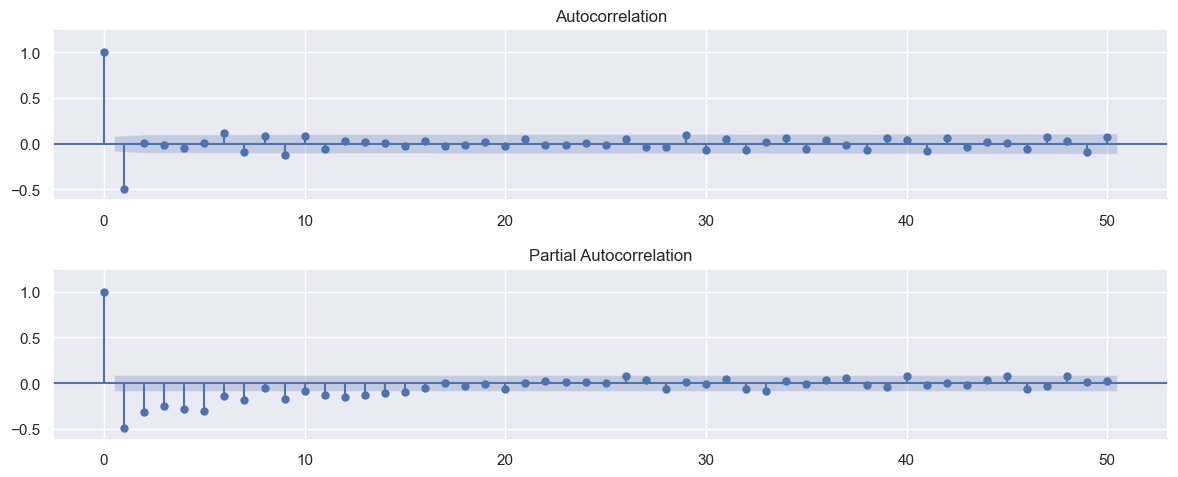

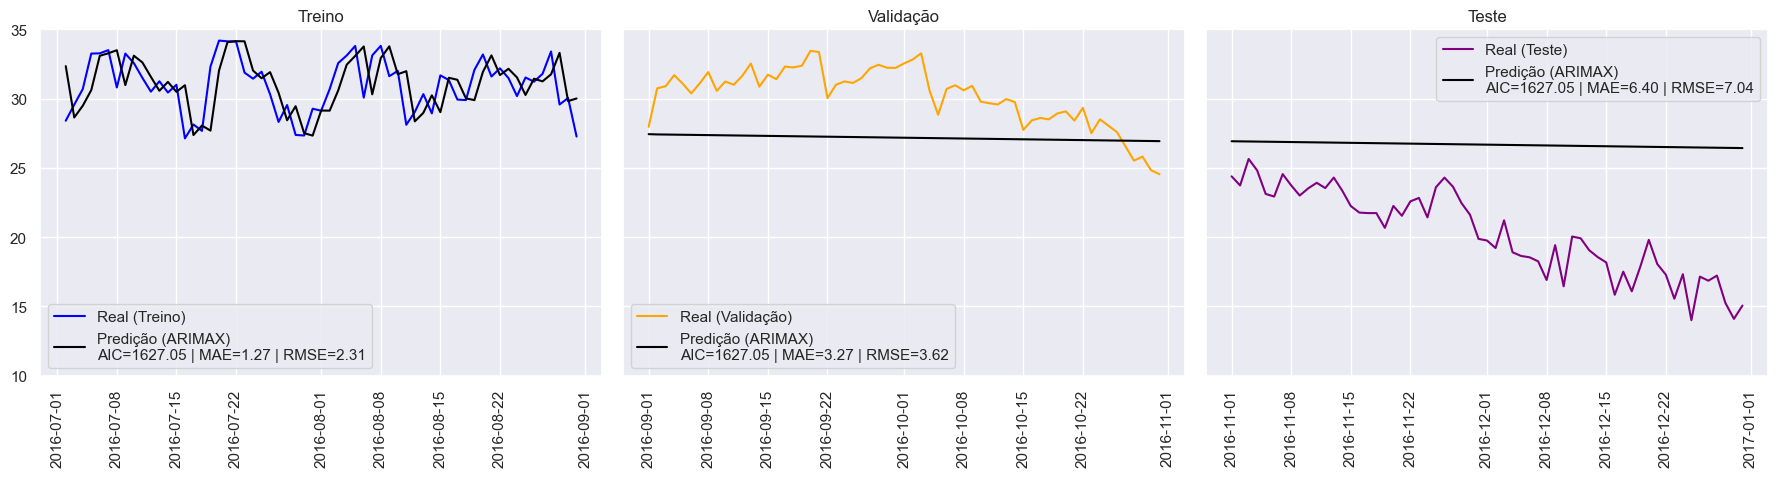

In [217]:
plota_acf_pacf(df_model['meantemp_diff2'], n_lags = 50)

# ==================== MODELO ARIMA ====================

arimax = ARIMA(
    df_model_train['meantemp'], 
    #exog=df_model_train[['humidity_diff2_lag1']], 
    order=(1, 2, 1),
)
arimax = arimax.fit()

############## Treino ##############

start = 0
end = len(df_model_train) - 1

pred_train = arimax.predict(
    start=start,
    end=end,
    #exog=df_model_valid[['humidity_diff2_lag1']], 
)

mae_train = mean_absolute_error(df_model_train['meantemp'], pred_train)
rmse_train = np.sqrt(mean_squared_error(df_model_train['meantemp'], pred_train))
aic_train = arimax.aic


############## Validação ##############
start = len(df_model_train)
end = start + len(df_model_valid) - 1

pred_valid = arimax.predict(
    start=start,
    end=end,
    #exog=df_model_valid[['humidity_diff2_lag1']], 
)

mae_valid = mean_absolute_error(df_model_valid['meantemp'], pred_valid)
rmse_valid = np.sqrt(mean_squared_error(df_model_valid['meantemp'], pred_valid))
aic_valid = arimax.aic

############## Teste ##############
start = len(df_model_train) + len(df_model_valid)
end = start + len(df_model_test) - 1

pred_test = arimax.predict(
    start=start,
    end=end,
    #exog=df_model_test[['humidity_diff2_lag1']], 
)


mae_test = mean_absolute_error(df_model_test['meantemp'], pred_test)
rmse_test = np.sqrt(mean_squared_error(df_model_test['meantemp'], pred_test))
aic_test = arimax.aic


# ========== GRÁFICO COM SUBPLOTS ==========
fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)

# TREINO
legend_train = f'Predição (ARIMAX)\nAIC={aic_train:.2f} | MAE={mae_train:.2f} | RMSE={rmse_train:.2f}'
axes[0].plot(df_model_train[-61:]['date'], df_model_train[-61:]['meantemp'], label='Real (Treino)', color='blue')
axes[0].plot(df_model_train[-61:]['date'], pred_train[-61:], label=legend_train, color='black')
axes[0].set_title('Treino')
axes[0].legend()
axes[0].set_ylim(0, 40)
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# VALIDAÇÃO
legend_val = f'Predição (ARIMAX)\nAIC={aic_valid:.2f} | MAE={mae_valid:.2f} | RMSE={rmse_valid:.2f}'
axes[1].plot(df_model_valid['date'], df_model_valid['meantemp'], label='Real (Validação)', color='orange')
axes[1].plot(df_model_valid['date'], pred_valid, label=legend_val, color='black')
axes[1].set_title('Validação')
axes[1].legend()
axes[1].set_ylim(0, 40)
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

# TESTE
legend_test = f'Predição (ARIMAX)\nAIC={aic_test:.2f} | MAE={mae_test:.2f} | RMSE={rmse_test:.2f}'
axes[2].plot(df_model_test['date'], df_model_test['meantemp'], label='Real (Teste)', color='purple')
axes[2].plot(df_model_test['date'], pred_test, label=legend_test, color='black')
axes[2].set_title('Teste')
axes[2].legend()
axes[2].set_ylim(10, 35)
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True)

plt.tight_layout()
plt.show()

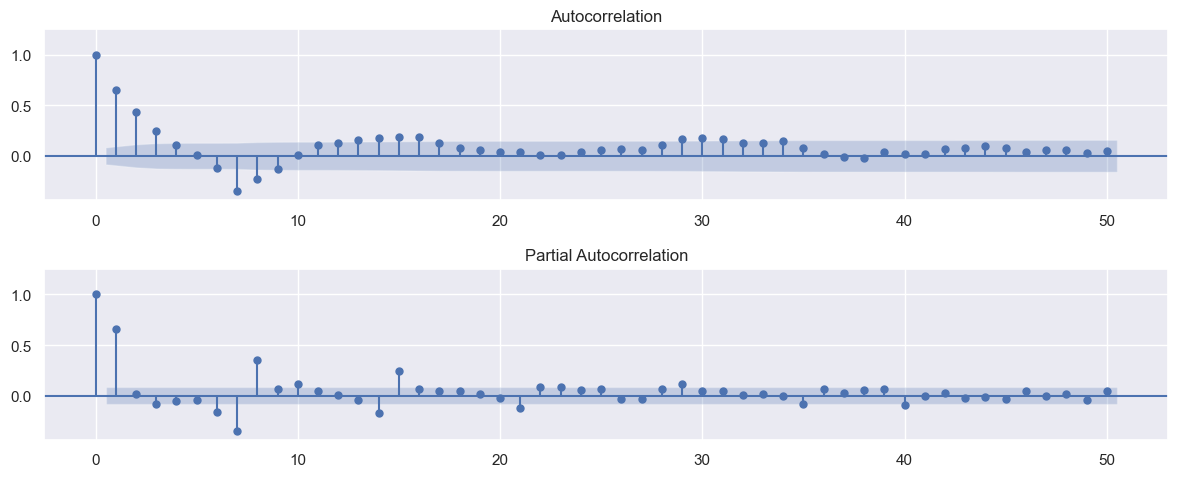

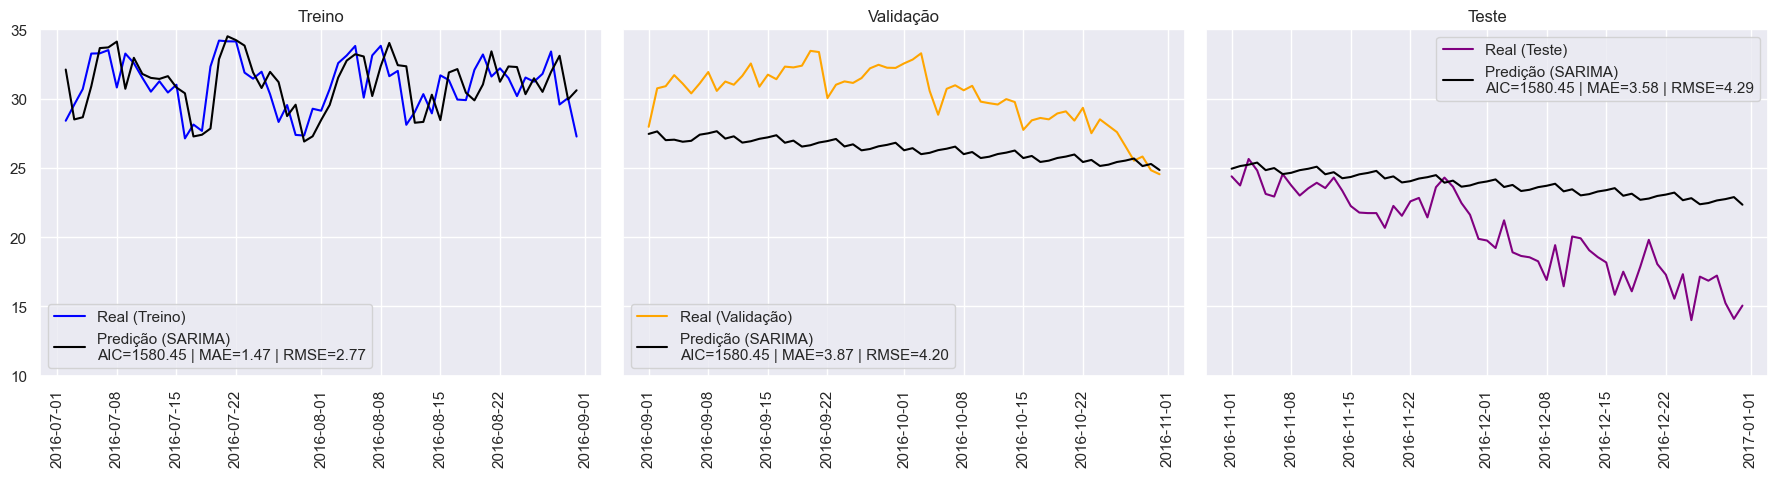

In [218]:
plota_acf_pacf(df_model['meantemp_seasonal_diff'], n_lags = 50)

# ==================== MODELO SARIMA ====================

sarima_model = SARIMAX(
    df_model_train['meantemp'],
    order=(1, 2, 1),
    seasonal_order=(1, 1, 1, 7),  # sazonalidade anual (365 dias)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_model = sarima_model.fit()

# ==================== TREINO ====================
start = 0
end = len(df_model_train) - 1

pred_train = sarima_model.predict(start=start, end=end)

mae_train = mean_absolute_error(df_model_train['meantemp'], pred_train)
rmse_train = np.sqrt(mean_squared_error(df_model_train['meantemp'], pred_train))
aic_train = sarima_model.aic

# ==================== VALIDAÇÃO ====================
start = len(df_model_train)
end = start + len(df_model_valid) - 1

pred_valid = sarima_model.predict(start=start, end=end)

mae_valid = mean_absolute_error(df_model_valid['meantemp'], pred_valid)
rmse_valid = np.sqrt(mean_squared_error(df_model_valid['meantemp'], pred_valid))
aic_valid = sarima_model.aic

# ==================== TESTE ====================
start = len(df_model_train) + len(df_model_valid)
end = start + len(df_model_test) - 1

pred_test = sarima_model.predict(start=start, end=end)

mae_test = mean_absolute_error(df_model_test['meantemp'], pred_test)
rmse_test = np.sqrt(mean_squared_error(df_model_test['meantemp'], pred_test))
aic_test = sarima_model.aic

# ==================== PLOT ====================
fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)

# TREINO
legend_train = f'Predição (SARIMA)\nAIC={aic_train:.2f} | MAE={mae_train:.2f} | RMSE={rmse_train:.2f}'
axes[0].plot(df_model_train[-61:]['date'], df_model_train[-61:]['meantemp'], label='Real (Treino)', color='blue')
axes[0].plot(df_model_train[-61:]['date'], pred_train[-61:], label=legend_train, color='black')
axes[0].set_title('Treino')
axes[0].legend()
axes[0].set_ylim(0, 40)
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# VALIDAÇÃO
legend_val = f'Predição (SARIMA)\nAIC={aic_valid:.2f} | MAE={mae_valid:.2f} | RMSE={rmse_valid:.2f}'
axes[1].plot(df_model_valid['date'], df_model_valid['meantemp'], label='Real (Validação)', color='orange')
axes[1].plot(df_model_valid['date'], pred_valid, label=legend_val, color='black')
axes[1].set_title('Validação')
axes[1].legend()
axes[1].set_ylim(0, 40)
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

# TESTE
legend_test = f'Predição (SARIMA)\nAIC={aic_test:.2f} | MAE={mae_test:.2f} | RMSE={rmse_test:.2f}'
axes[2].plot(df_model_test['date'], df_model_test['meantemp'], label='Real (Teste)', color='purple')
axes[2].plot(df_model_test['date'], pred_test, label=legend_test, color='black')
axes[2].set_title('Teste')
axes[2].legend()
axes[2].set_ylim(10, 35)
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True)

plt.tight_layout()
plt.show()


# <font color='green' style='font-size: 30px;'> 4.2) Modelos de Machine Learning - Random Forest e LightGBM </font>
<hr style='border: 2px solid green;'>

> 1. Inicialmente realizou-se um Feature Selection para entender as variáveis mais importantes, optando por manter as Features com Feature Importance >= 0.05

> 2. Testou-se uma Random Forest e o LightGBM, duas metodologias de Ensemble de Árvores:

- As metodologias de árvore possuem alto poder preditivo e não requerem premissas sobre os ruídos ou algo do tipo, facilitando a modelagem

- Os resultados foram muito satisfatórios em ambas as metodologias

In [219]:
x_train, y_train = separa_feature_target('meantemp', ['sample','date', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_log', 'meantemp_diff2', 'meantemp_log_diff2', 'meantemp_seasonal_diff'], df_model_train)
x_valid, y_valid = separa_feature_target('meantemp', ['sample','date', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_log', 'meantemp_diff2', 'meantemp_log_diff2', 'meantemp_seasonal_diff'], df_model_valid)
x_test, y_test = separa_feature_target('meantemp', ['sample','date', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_log', 'meantemp_diff2', 'meantemp_log_diff2', 'meantemp_seasonal_diff'], df_model_test)

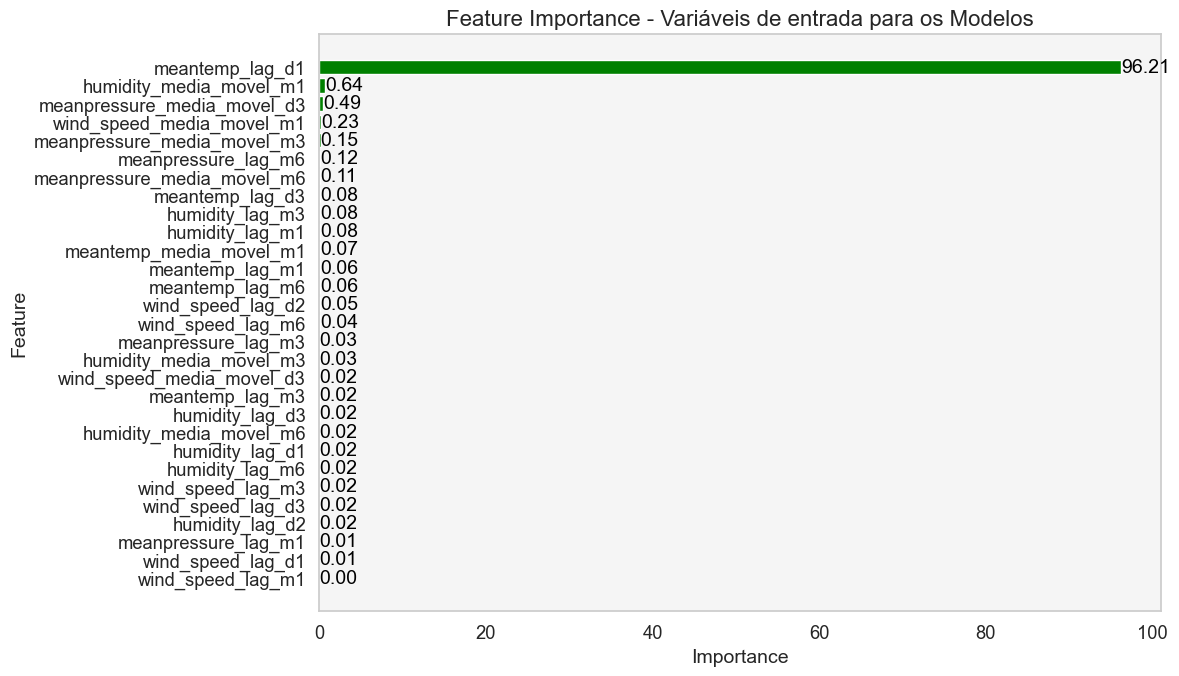

In [220]:
# Seleciona Variaveis Finais que passaram pela Feature Importance + Análise de Correlação
variaveis_finais = aplica_feature_selection('meantemp', ['sample', 'date', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_log', 'meantemp_diff2', 'meantemp_log_diff2', 'meantemp_seasonal_diff'], df_model_train, 0)

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.2)

bars = plt.barh(variaveis_finais['feature'], variaveis_finais['importance'], color='green')
plt.title("Feature Importance - Variáveis de entrada para os Modelos", fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black', fontsize=14)


plt.tight_layout()
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.gca().invert_yaxis()
plt.show()


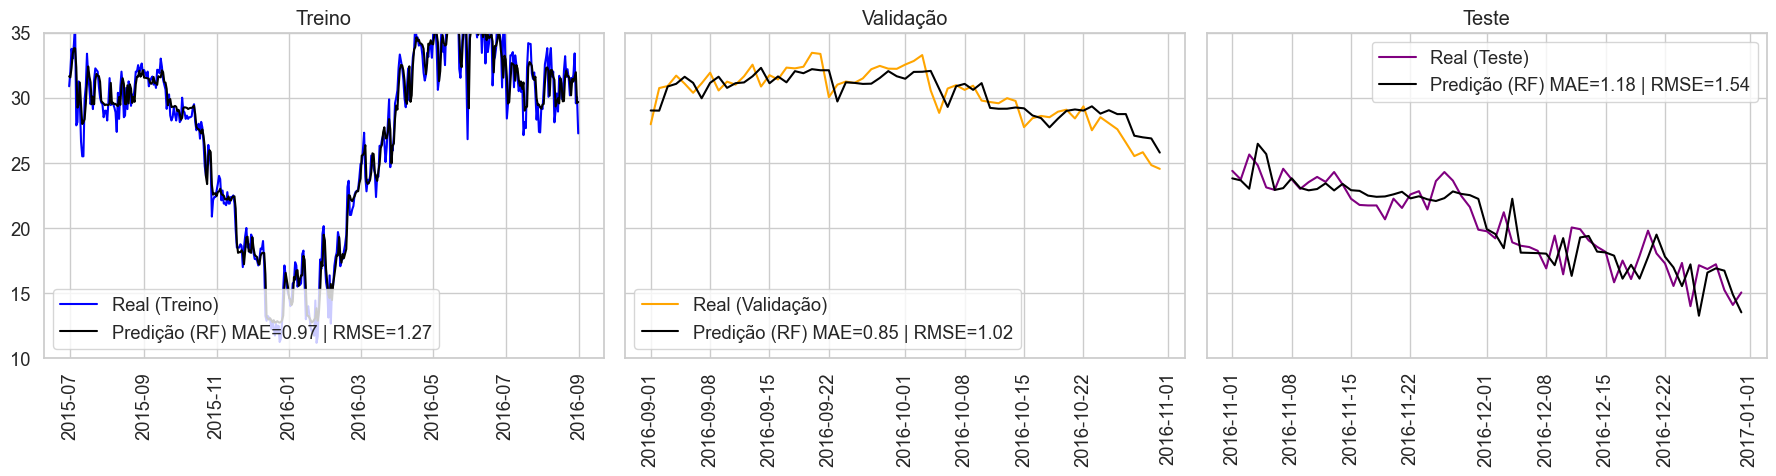

In [221]:
features = ['meantemp_lag_d1', 'humidity_media_movel_m1',
'meanpressure_media_movel_d3', 'wind_speed_media_movel_m1',
'meanpressure_media_movel_m3', 'meanpressure_lag_m6',
'meanpressure_media_movel_m6', 'meantemp_lag_d3',
'humidity_lag_m3', 'humidity_lag_m1', 'meantemp_media_movel_m1',
'meantemp_lag_m1', 'meantemp_lag_m6', 'wind_speed_lag_d2',
'wind_speed_lag_m6', 'meanpressure_lag_m3',
'humidity_media_movel_m3', 'wind_speed_media_movel_d3',
'meantemp_lag_m3', 'humidity_lag_d3', 'humidity_media_movel_m6',
'humidity_lag_d1', 'humidity_lag_m6', 'wind_speed_lag_m3',
'wind_speed_lag_d3', 'humidity_lag_d2', 'meanpressure_lag_m1',
'wind_speed_lag_d1', 'wind_speed_lag_m1']

modelo_random_forest = RandomForestRegressor(
    random_state=42,            # Semente aleatória para reproducibilidade dos resultados
    criterion='squared_error',       # Critério usado para medir a qualidade de uma divisão
    n_estimators=50,           # Número de árvores na floresta (equivalente ao n_estimators no XGBoost)
    max_depth = 4,                # Profundidade máxima de cada árvore
    bootstrap=True               # Se deve ou não amostrar com substituição ao construir árvores
    )

modelo_random_forest.fit(x_train[features], y_train)

# ==================== TREINO ====================
pred_train = modelo_random_forest.predict(df_model_train[features])

mae_train = mean_absolute_error(df_model_train['meantemp'], pred_train)
rmse_train = np.sqrt(mean_squared_error(df_model_train['meantemp'], pred_train))

# ==================== VALIDAÇÃO ====================
pred_valid = modelo_random_forest.predict(df_model_valid[features])

mae_valid = mean_absolute_error(df_model_valid['meantemp'], pred_valid)
rmse_valid = np.sqrt(mean_squared_error(df_model_valid['meantemp'], pred_valid))

# ==================== TESTE ====================
pred_test = modelo_random_forest.predict(df_model_test[features])

mae_test = mean_absolute_error(df_model_test['meantemp'], pred_test)
rmse_test = np.sqrt(mean_squared_error(df_model_test['meantemp'], pred_test))


# ==================== PLOT ====================
fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)

# TREINO
legend_train = f'Predição (RF) MAE={mae_train:.2f} | RMSE={rmse_train:.2f}'
axes[0].plot(df_model_train['date'], df_model_train['meantemp'], label='Real (Treino)', color='blue')
axes[0].plot(df_model_train['date'], pred_train, label=legend_train, color='black')
axes[0].set_title('Treino')
axes[0].legend()
axes[0].set_ylim(0, 40)
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# VALIDAÇÃO
legend_val = f'Predição (RF) MAE={mae_valid:.2f} | RMSE={rmse_valid:.2f}'
axes[1].plot(df_model_valid['date'], df_model_valid['meantemp'], label='Real (Validação)', color='orange')
axes[1].plot(df_model_valid['date'], pred_valid, label=legend_val, color='black')
axes[1].set_title('Validação')
axes[1].legend()
axes[1].set_ylim(0, 40)
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

# TESTE
legend_test = f'Predição (RF) MAE={mae_test:.2f} | RMSE={rmse_test:.2f}'
axes[2].plot(df_model_test['date'], df_model_test['meantemp'], label='Real (Teste)', color='purple')
axes[2].plot(df_model_test['date'], pred_test, label=legend_test, color='black')
axes[2].set_title('Teste')
axes[2].legend()
axes[2].set_ylim(10, 35)
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True)

plt.tight_layout()
plt.show()

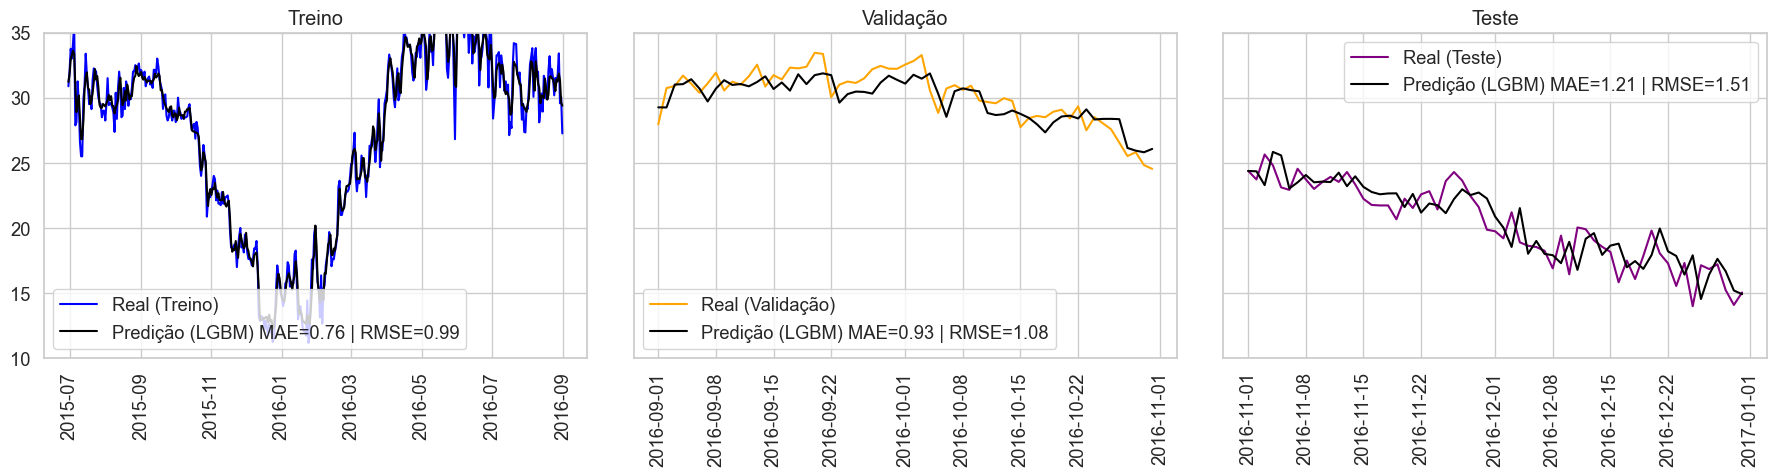

In [222]:
# ========== MODELO LGBM ==========
modelo_lgbm = LGBMRegressor(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

modelo_lgbm.fit(x_train[features], y_train)

# ========== TREINO ==========
pred_train = modelo_lgbm.predict(df_model_train[features])
mae_train = mean_absolute_error(df_model_train['meantemp'], pred_train)
rmse_train = np.sqrt(mean_squared_error(df_model_train['meantemp'], pred_train))

# ========== VALIDAÇÃO ==========
pred_valid = modelo_lgbm.predict(df_model_valid[features])
mae_valid = mean_absolute_error(df_model_valid['meantemp'], pred_valid)
rmse_valid = np.sqrt(mean_squared_error(df_model_valid['meantemp'], pred_valid))

# ========== TESTE ==========
pred_test = modelo_lgbm.predict(df_model_test[features])
mae_test = mean_absolute_error(df_model_test['meantemp'], pred_test)
rmse_test = np.sqrt(mean_squared_error(df_model_test['meantemp'], pred_test))

# ========== PLOT ==========
fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)

# TREINO
legend_train = f'Predição (LGBM) MAE={mae_train:.2f} | RMSE={rmse_train:.2f}'
axes[0].plot(df_model_train['date'], df_model_train['meantemp'], label='Real (Treino)', color='blue')
axes[0].plot(df_model_train['date'], pred_train, label=legend_train, color='black')
axes[0].set_title('Treino')
axes[0].legend()
axes[0].set_ylim(0, 40)
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# VALIDAÇÃO
legend_val = f'Predição (LGBM) MAE={mae_valid:.2f} | RMSE={rmse_valid:.2f}'
axes[1].plot(df_model_valid['date'], df_model_valid['meantemp'], label='Real (Validação)', color='orange')
axes[1].plot(df_model_valid['date'], pred_valid, label=legend_val, color='black')
axes[1].set_title('Validação')
axes[1].legend()
axes[1].set_ylim(0, 40)
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

# TESTE
legend_test = f'Predição (LGBM) MAE={mae_test:.2f} | RMSE={rmse_test:.2f}'
axes[2].plot(df_model_test['date'], df_model_test['meantemp'], label='Real (Teste)', color='purple')
axes[2].plot(df_model_test['date'], pred_test, label=legend_test, color='black')
axes[2].set_title('Teste')
axes[2].legend()
axes[2].set_ylim(10, 35)
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True)

plt.tight_layout()
plt.show()


# <font color='green' style='font-size: 30px;'> 4.3) Modelos de Deep Learning - LSTM </font>
<hr style='border: 2px solid green;'>

> 1. As LSTM são Redes Neurais Recorrente que procesam sequencias, sendo excelentes para Séries Temporais. A LSTM trabalha com um mecanismo de portas que controla o fluxo de informação ao longo do tempo. A Porta de Esquecimento (Forget Gate) decide quais informações das células de memória anterior devem ser descartadas; a Porta de Entrada (Input Gate) determina quais novas informações serão armazenadas na célula de memória atual, agindo como uma memória de longo prazo; a Porta de Saída (Output Gate), que representa a memória de curto prazo e será usada para a predição da saída Yt. Esse mecanismo permite que o modelo mantenha apenas as informações relevantes ao longo do tempo, resolvendo o problema de desaparecimento do gradiente

> 2. Para essa LSTM, escolheu-se:

- Épocas e Batch Size: O treinameno ocorre em 50 épocas, onde em cada época:
    - A LSTM recebe um Tensor (Estruturas que representam Vetores Multidimensionais) com o batch_size (32 sequencias), as Lags (30) e as Fetures (meantemp)
    - Isso significa que a cada Batch, o modelo irá procesar 32 séries paralelamente (Cada série diz respeito às 30 Lags solicitadas) da variável meantemp

- Topologia:
    - A camada de entrada possui 30 neurônios (pensar na forma de um Vetor de Lags chamado $L^T$)
    - Utilizou-se 64 neurônios, de modo que cada neurônio receberá a sequência (série correspondente às 30 Lags solicitadas - pensar na forma de um Vetor de Lags chamado $L$), cada um com um peso específico
    - Os pesos serão atualizados via Backpropagation
    - A rede possui apenas 1 camada de entrada e 1 camada de saída
    - Por padrão, a camada LSTM do Keras usa a Sigmóide para a Porta de Entrada, Tangente Hiperbólica para a Porta de Saída e Linear para a Camada de Saída

- Resultados foram muito satisfatórios

Epoch 1/50
13/13 [==============================] - 1s 25ms/step - loss: 0.1206 - val_loss: 0.0558
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0192 - val_loss: 0.0051
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0145 - val_loss: 0.0072
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0020
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0042
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0023
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 8/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0021
Epoch 9/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0025


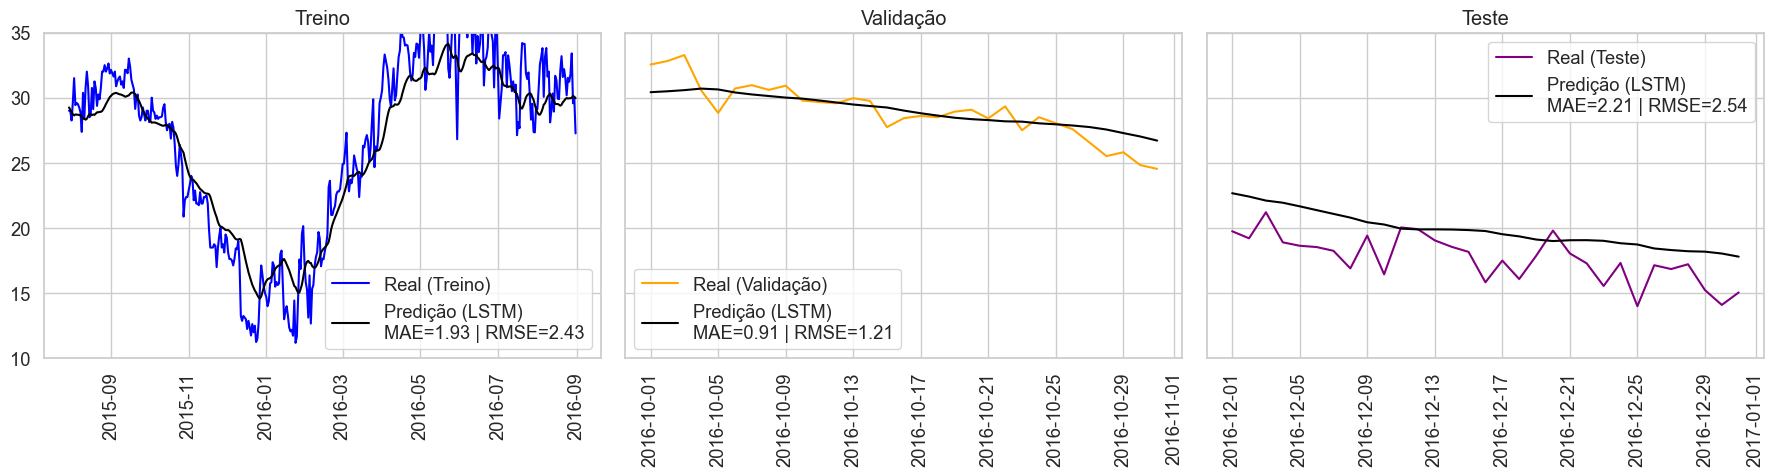

In [223]:
# ========= PARÂMETROS =========
lags = 30  # dias de memória
epochs = 50
batch_size = 32

# ========= FUNÇÃO DE JANELA =========
def create_sequences(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i + lags])
        y.append(data[i + lags])
    return np.array(X), np.array(y)

# ========= ESCALAR =========
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_model_train[['meantemp']])
valid_scaled = scaler.transform(df_model_valid[['meantemp']])
test_scaled  = scaler.transform(df_model_test[['meantemp']])

# ========= JANELAS =========
X_train, y_train = create_sequences(train_scaled, lags)
X_valid, y_valid = create_sequences(valid_scaled, lags)
X_test, y_test   = create_sequences(test_scaled, lags)

# Reshape para LSTM [amostras, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], lags, 1)
X_valid = X_valid.reshape(X_valid.shape[0], lags, 1)
X_test  = X_test.reshape(X_test.shape[0], lags, 1)

# ========= MODELO LSTM =========
model = Sequential([
    LSTM(64, input_shape=(lags, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# ========= PREVISÕES =========
pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)
pred_test  = model.predict(X_test)

# ========= INVERTER ESCALA =========
pred_train = scaler.inverse_transform(pred_train)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
pred_valid = scaler.inverse_transform(pred_valid)
y_valid = scaler.inverse_transform(y_valid.reshape(-1, 1))
pred_test = scaler.inverse_transform(pred_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# ========= MÉTRICAS =========
mae_train = mean_absolute_error(y_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

mae_valid = mean_absolute_error(y_valid, pred_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid, pred_valid))

mae_test = mean_absolute_error(y_test, pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

# ========= PLOT =========
fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)

# TREINO
legend_train = f'Predição (LSTM)\nMAE={mae_train:.2f} | RMSE={rmse_train:.2f}'
axes[0].plot(df_model_train[-(len(y_train)):]['date'], y_train, label='Real (Treino)', color='blue')
axes[0].plot(df_model_train[-(len(y_train)):]['date'], pred_train, label=legend_train, color='black')
axes[0].set_title('Treino')
axes[0].legend()
axes[0].set_ylim(0, 40)
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# VALIDAÇÃO
legend_val = f'Predição (LSTM)\nMAE={mae_valid:.2f} | RMSE={rmse_valid:.2f}'
axes[1].plot(df_model_valid[-(len(y_valid)):]['date'], y_valid, label='Real (Validação)', color='orange')
axes[1].plot(df_model_valid[-(len(y_valid)):]['date'], pred_valid, label=legend_val, color='black')
axes[1].set_title('Validação')
axes[1].legend()
axes[1].set_ylim(0, 40)
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

# TESTE
legend_test = f'Predição (LSTM)\nMAE={mae_test:.2f} | RMSE={rmse_test:.2f}'
axes[2].plot(df_model_test[-(len(y_test)):]['date'], y_test, label='Real (Teste)', color='purple')
axes[2].plot(df_model_test[-(len(y_test)):]['date'], pred_test, label=legend_test, color='black')
axes[2].set_title('Teste')
axes[2].legend()
axes[2].set_ylim(10, 35)
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True)

plt.tight_layout()
plt.show()
